## Surface Buoyancy
Some evidence showed that surface buoyancy could potentially play an important role in driving the variability in the melt shown in our results. That hypothesis is tested in this document

In [1]:
from functions.correlation_maps import simpleCorrelationMap, correlationMap_1D_v3, correlationMap_2D_v3#, correlationMap_2D, correlationMap_1D,
from functions.loading_and_processing_data import loadMITgcmData, loadTimeSeriesData, detrend_and_average_MITgcmData
from functions.other_functions import computeBuoyancy
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

Read buoyancy data.

In [101]:
#data=computeBuoyancy(member=1)

data=None
for member in range(1,21):
    ds=computeBuoyancy(member=member)
    if type(data)==type(None):
        data=ds
    else:
        data=xr.concat([data, ds], dim='ens')

...computing Buoyancy Forcing using EOS for member 1
...computing Buoyancy Forcing using EOS for member 2
...computing Buoyancy Forcing using EOS for member 3
...computing Buoyancy Forcing using EOS for member 4
...computing Buoyancy Forcing using EOS for member 5
...computing Buoyancy Forcing using EOS for member 6
...computing Buoyancy Forcing using EOS for member 7
...computing Buoyancy Forcing using EOS for member 8
...computing Buoyancy Forcing using EOS for member 9
...computing Buoyancy Forcing using EOS for member 10
...computing Buoyancy Forcing using EOS for member 11
...computing Buoyancy Forcing using EOS for member 12
...computing Buoyancy Forcing using EOS for member 13
...computing Buoyancy Forcing using EOS for member 14
...computing Buoyancy Forcing using EOS for member 15
...computing Buoyancy Forcing using EOS for member 16
...computing Buoyancy Forcing using EOS for member 17
...computing Buoyancy Forcing using EOS for member 18
...computing Buoyancy Forcing using E

In [102]:
data=data.where(data['Depth']!=0, drop=True).where(data['oceBUOY'].isel(ens=0, time=1000)!=0, drop=True)


Load other data of interest

In [3]:
%%capture

wind=loadTimeSeriesData(filename='timeseries_final', members='all', kind='old')['amundsen_shelf_break_uwind_avg']
wind['time']=wind.indexes['time'].to_datetimeindex()
melt=loadTimeSeriesData(filename='timeseries_final', members='all', kind='old')['dotson_to_cosgrove_massloss']
melt['time']=melt.indexes['time'].to_datetimeindex()

adv={}
for loc in ['UW115', 'PITE', 'coastal']:
    if loc=='UW115':
        adv[loc]=xr.open_dataarray('/data/hpcdata/users/grejan/mitgcm/02_data/indices/undercurrent_W115.nc')
        adv[loc]['time']=adv[loc].indexes['time'].to_datetimeindex()
    else:
        adv[loc]=xr.open_dataarray('/data/hpcdata/users/grejan/mitgcm/02_data/indices/ADVy_TH_'+loc+'.nc')
        adv[loc]['time']=adv[loc].indexes['time'].to_datetimeindex()
        adv[loc+'_bottom100m']=xr.open_dataarray('/data/hpcdata/users/grejan/mitgcm/02_data/indices/ADVy_TH_'+loc+'_bottom100m.nc')
        adv[loc+'_bottom100m']['time']=adv[loc+'_bottom100m'].indexes['time'].to_datetimeindex()


Show which part of the domain you want to select as an index.

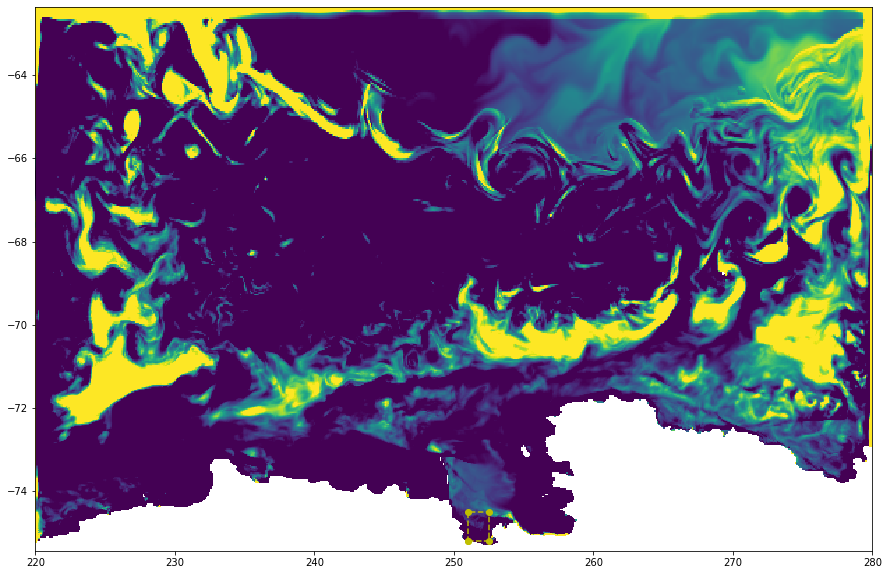

In [74]:
plt.figure(figsize=(15,10))
plt.pcolor(data['oceBUOY'].sel(ens=0).XC, data['oceBUOY'].sel(ens=0).YC, data['oceBUOY'].sel(ens=0).sel(time=slice('1920', '2013')).isel(time=20), vmin=-1e-5, vmax=1e-5)
plt.plot([251, 252.5, 252.5, 251, 251], [-75.2, -75.2, -74.5, -74.5, -75.2], 'yo--')

Create the index.

In [103]:
#Do this in a proper way (i.e. control for differences in cell size)
tc=data.sel(YC=slice(-75.2, -74.5), XC=slice(251, 252.5))
tc=(tc['oceBUOY']*tc['rA'])/tc['rA'].sum()
tc=tc.mean(dim=['YC', 'XC'])
tc['time']=tc.indexes['time'].to_datetimeindex()

/tmp/ipykernel_17586/351951857.py:5: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  tc['time']=tc.indexes['time'].to_datetimeindex()


In [13]:
#tc.to_netcdf('../02_data/indices/oceBUOY_icefront.nc')
tc=xr.open_dataarray('../02_data/indices/oceBUOY_icefront.nc')

Show the index in a plot.

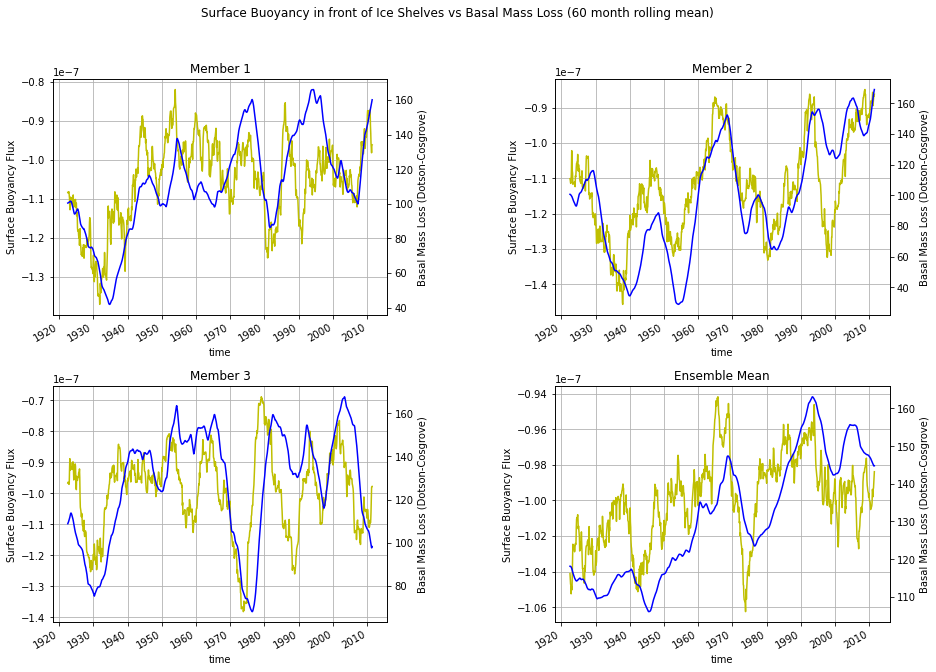

In [229]:
plt.figure(figsize=(15, 10))
for i in range(3):
    plt.subplot(2,2,i+1)
    tc.sel(ens=i).sel(time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(color='y')
    plt.title('Member '+str(i+1))
    plt.ylabel('Surface Buoyancy Flux')
    plt.grid()
    plt.twinx()
    melt.sel(ens=i, time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(color='b')
    plt.ylabel('Basal Mass Loss (Dotson-Cosgrove)')


plt.subplot(2,2,4)
tc.mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(color='y')
plt.title('Ensemble Mean')
plt.ylabel('Surface Buoyancy Flux')
plt.grid()
plt.twinx()
melt.mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(color='b')
plt.ylabel('Basal Mass Loss (Dotson-Cosgrove)')  
    
    


plt.suptitle('Surface Buoyancy in front of Ice Shelves vs Basal Mass Loss (60 month rolling mean)')
plt.subplots_adjust(hspace=0.3, wspace=0.5)
plt.savefig('../03_output/timeseries/oceBUOY_vs_melt_timeseries.png')

    


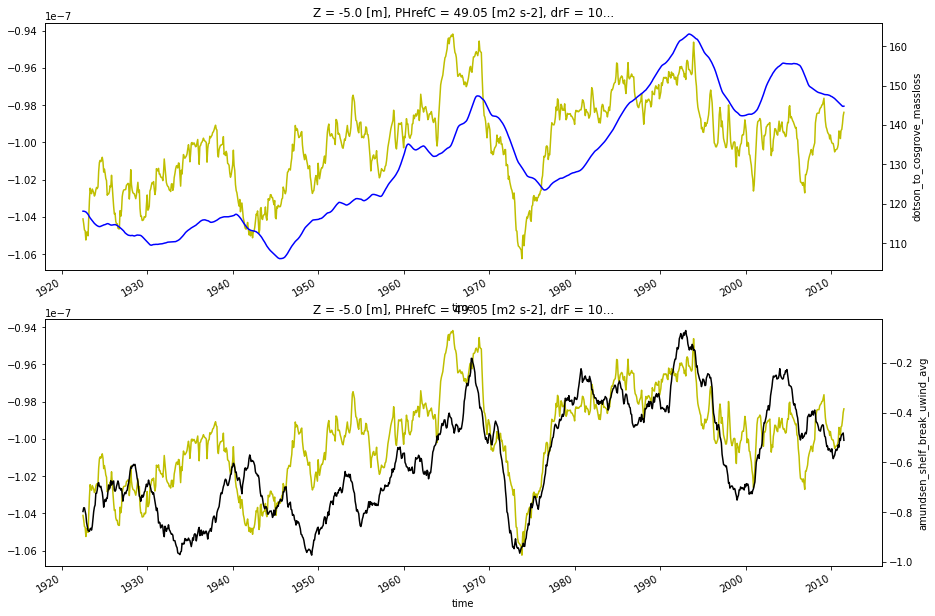

In [104]:
plt.figure(figsize=(15, 10))
# plt.subplot(2,1,1)
# tc.sel(ens=0).sel(time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(color='y')
# plt.twinx()
# melt.sel(ens=0, time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(color='b')

# plt.subplot(2,1,2)
# tc.sel(ens=0).sel(time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(color='y')
# plt.twinx()
# wind.sel(ens=0, time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(color='k')

plt.subplot(2,1,1)
tc.mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(color='y')
plt.twinx()
melt.mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(color='b')

plt.subplot(2,1,2)
tc.mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(color='y')
plt.twinx()
wind.mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(color='k')

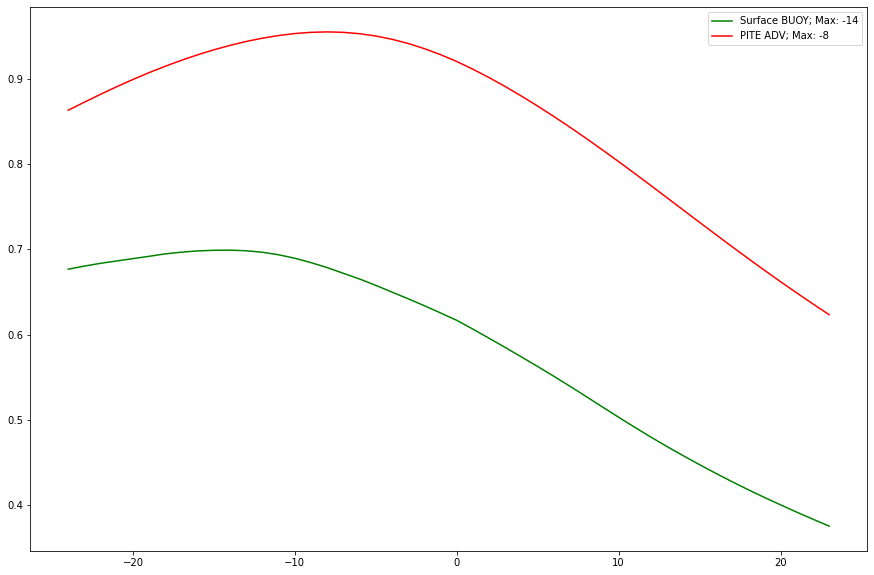

In [105]:
cor1=[]
cor2=[]
a=tc.sel(ens=1, time=slice('1920', '2013')).rolling(time=24, center=True).mean()
b=melt.sel(ens=1, time=slice('1920', '2013')).rolling(time=24, center=True).mean()
c=adv['PITE'].sel(ens=1, time=slice('1920', '2013')).rolling(time=24, center=True).mean()

for i in range(-24, 24):
    cor1+=[xr.corr(a, b.shift(time=i), dim='time')]
    cor2+=[xr.corr(c, b.shift(time=i), dim='time')*-1]

plt.figure(figsize=(15, 10))    
plt.plot(range(-24, 24), cor1, label='Surface BUOY; Max: '+str(np.argmax(cor1)-24), c='g')
plt.plot(range(-24, 24), cor2, label='PITE ADV; Max: '+str(np.argmax(cor2)-24), c='r')
plt.legend()

In [319]:
tc_dt=detrend_and_average_MITgcmData(tc.to_dataset(name='oceBUOY'), var='oceBUOY', window=1)
adv_dt=detrend_and_average_MITgcmData(adv['PITE'].to_dataset(name='ADVy_TH'), var='ADVy_TH', window=1)
melt_dt=detrend_and_average_MITgcmData(melt.to_dataset(name='dotson_to_cosgrove_massloss'), var='dotson_to_cosgrove_massloss', window=1)

In [ ]:
#I should actually detrend this; save alles
window=12
plt.figure(figsize=(15, 10))    
for j in range(20):
    cor1=[]
    cor2=[]
    cor3=[]
#     a=tc.sel(ens=j, time=slice('1920', '2013')).rolling(time=60, center=True).mean()
#     b=melt.sel(ens=j, time=slice('1920', '2013')).rolling(time=60, center=True).mean()
#     c=adv['PITE'].sel(ens=j, time=slice('1920', '2013')).rolling(time=60, center=True).mean()
    
    a=tc_dt.sel(ens=j, time=slice('1920', '2013')).rolling(time=window, center=True).mean()
    b=melt_dt.sel(ens=j, time=slice('1920', '2013')).rolling(time=window, center=True).mean()
    c=adv_dt.sel(ens=j, time=slice('1920', '2013')).rolling(time=window, center=True).mean()

    if window==1:
        def deseasonalize(ds):
            monthly=ds.groupby('time.month').mean()
            return ds.groupby('time.month')-monthly
        a=deseasonalize(a)
        b=deseasonalize(b)
        c=deseasonalize(c)
            
    
    for i in range(-30, 24):
        cor1+=[xr.corr(a, b.shift(time=i), dim='time')]
        cor2+=[xr.corr(c, b.shift(time=i), dim='time')*-1]
        cor3+=[xr.corr(a, c.shift(time=i), dim='time')*-1]
    plt.subplot(3,1,1)
    plt.plot(range(-30, 24), cor1, c='grey', linewidth=0.3)
    plt.subplot(3,1,2)
    plt.plot(range(-30, 24), cor2, c='grey', linewidth=0.3)
    plt.subplot(3,1,3)
    plt.plot(range(-30, 24), cor3, c='grey', linewidth=0.3)
    
    if j==0:
        cor1_list=np.asarray(cor1)
        cor2_list=np.asarray(cor2)
        cor3_list=np.asarray(cor3)
    else:
        cor1_list=np.vstack((cor1_list, cor1))
        cor2_list=np.vstack((cor2_list, cor2))
        cor3_list=np.vstack((cor3_list, cor3))
 
 

plt.subplot(3,1,1)
plt.plot(range(-30, 24), np.mean(cor1_list, axis=0), label='Mean; Max: '+str(np.argmax(np.mean(cor1_list, axis=0))-30), c='black', linewidth=1.3)
plt.subplot(3,1,2)
plt.plot(range(-30, 24), np.mean(cor2_list, axis=0), label='Mean; Max: '+str(np.argmax(np.mean(cor2_list, axis=0))-30), c='black', linewidth=1.3)
plt.subplot(3,1,3)
plt.plot(range(-30, 24), np.mean(cor3_list, axis=0), label='Mean; Max: '+str(np.argmax(np.mean(cor3_list, axis=0))-30), c='black', linewidth=1.3)


plt.subplot(3,1,1)
plt.grid()
plt.xlabel('Lag (negative is BUOY is leading)')
plt.title('Corr between BUOY and MELT')
plt.legend()
plt.subplot(3,1,2)
plt.grid()
plt.xlabel('Lag (negative is PITE ADV is leading)')
plt.title('Corr between PITE ADV and MELT')
plt.legend()

plt.subplot(3,1,3)
plt.grid()
plt.xlabel('Lag (negative is BUOY is leading)')
plt.title('Corr between BUOY and PITE ADV')
plt.legend()

if window==1:
    plt.suptitle('Correlation with different lag ('+str(window)+' month rolling mean, detrended, deseasonalized)')
else:
    plt.suptitle('Correlation with different lag ('+str(window)+' month rolling mean, detrended)')

plt.subplots_adjust(hspace=0.5)

plt.savefig('../03_output/other/lag_BUOY_melt_and_current_rm'+str(window)+'.png')

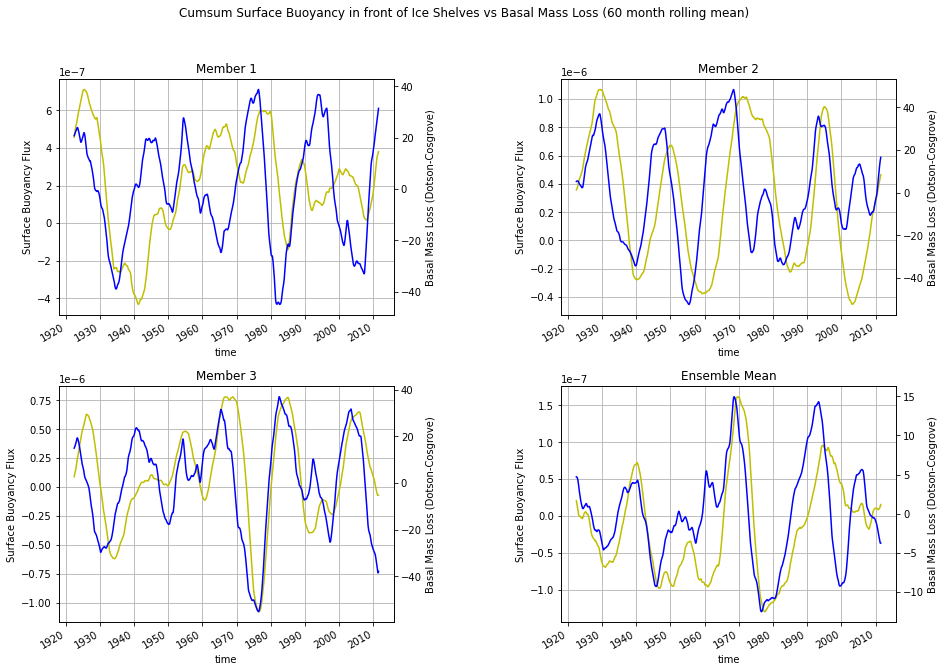

In [230]:
plt.figure(figsize=(15, 10))
for i in range(3):
    plt.subplot(2,2,i+1)
    (tc_dt.sel(ens=i).sel(time=slice('1920', '2013')).cumsum(dim='time')).rolling(time=60, center=True).mean().plot(color='y')
    plt.title('Member '+str(i+1))
    plt.ylabel('Surface Buoyancy Flux')
    plt.grid()
    plt.twinx()
    melt_dt.sel(ens=i, time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(color='b')
    plt.ylabel('Basal Mass Loss (Dotson-Cosgrove)')


plt.subplot(2,2,4)
(tc_dt.mean(dim='ens').sel(time=slice('1920', '2013')).cumsum(dim='time')).rolling(time=60, center=True).mean().plot(color='y')
plt.title('Ensemble Mean')
plt.ylabel('Surface Buoyancy Flux')
plt.grid()
plt.twinx()
melt_dt.mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(color='b')
plt.ylabel('Basal Mass Loss (Dotson-Cosgrove)')  
    
    


plt.suptitle('Cumsum Surface Buoyancy in front of Ice Shelves vs Basal Mass Loss (60 month rolling mean)')
plt.subplots_adjust(hspace=0.3, wspace=0.5)

plt.savefig('../03_output/timeseries/cumsum_oceBUOY_vs_melt_timeseries.png')

    


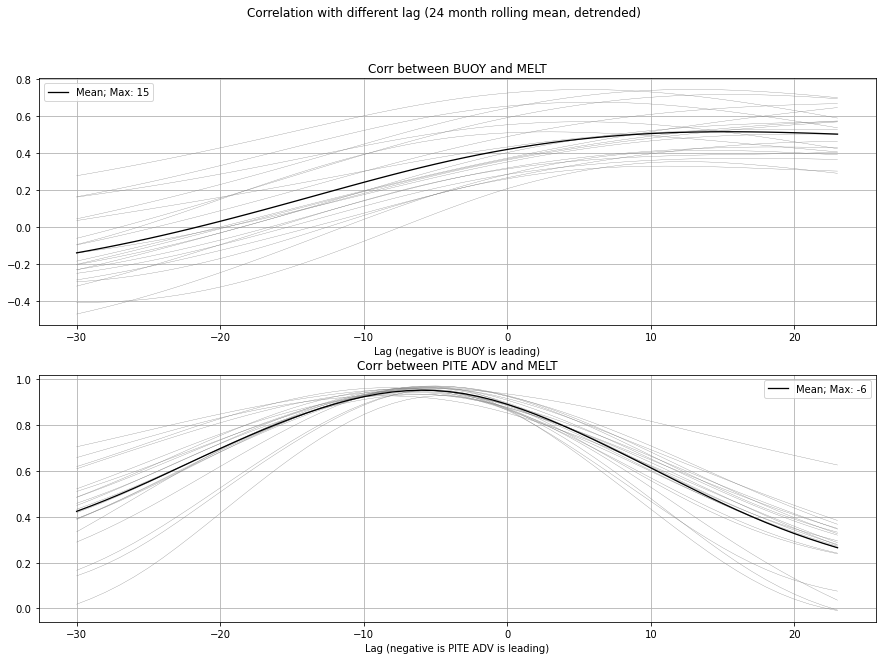

In [227]:
#I should actually detrend this; save alles
window=24
plt.figure(figsize=(15, 10))    
for j in range(20):
    cor1=[]
    cor2=[]
#     a=tc.sel(ens=j, time=slice('1920', '2013')).rolling(time=60, center=True).mean()
#     b=melt.sel(ens=j, time=slice('1920', '2013')).rolling(time=60, center=True).mean()
#     c=adv['PITE'].sel(ens=j, time=slice('1920', '2013')).rolling(time=60, center=True).mean()
    
    a=(tc_dt.sel(ens=j, time=slice('1920', '2013')).cumsum(dim='time')).rolling(time=window, center=True).mean()
    b=melt_dt.sel(ens=j, time=slice('1920', '2013')).rolling(time=window, center=True).mean()
    c=adv_dt.sel(ens=j, time=slice('1920', '2013')).rolling(time=window, center=True).mean()

    if window==1:
        def deseasonalize(ds):
            monthly=ds.groupby('time.month').mean()
            return ds.groupby('time.month')-monthly
        a=deseasonalize(a)
        b=deseasonalize(b)
        c=deseasonalize(c)
            
    
    for i in range(-30, 24):
        cor1+=[xr.corr(a, b.shift(time=i), dim='time')]
        cor2+=[xr.corr(c, b.shift(time=i), dim='time')*-1]
    plt.subplot(2,1,1)
    plt.plot(range(-30, 24), cor1, c='grey', linewidth=0.3)
    plt.subplot(2,1,2)
    plt.plot(range(-30, 24), cor2, c='grey', linewidth=0.3)
    
    if j==0:
        cor1_list=np.asarray(cor1)
        cor2_list=np.asarray(cor2)
    else:
        cor1_list=np.vstack((cor1_list, cor1))
        cor2_list=np.vstack((cor2_list, cor2))
 

plt.subplot(2,1,1)
plt.plot(range(-30, 24), np.mean(cor1_list, axis=0), label='Mean; Max: '+str(np.argmax(np.mean(cor1_list, axis=0))-30), c='black', linewidth=1.3)
plt.subplot(2,1,2)
plt.plot(range(-30, 24), np.mean(cor2_list, axis=0), label='Mean; Max: '+str(np.argmax(np.mean(cor2_list, axis=0))-30), c='black', linewidth=1.3)

plt.subplot(2,1,1)
plt.grid()
plt.xlabel('Lag (negative is BUOY is leading)')
plt.title('Corr between BUOY and MELT')
plt.legend()
plt.subplot(2,1,2)
plt.grid()
plt.xlabel('Lag (negative is PITE ADV is leading)')
plt.title('Corr between PITE ADV and MELT')
if window==1:
    plt.suptitle('Correlation with different lag ('+str(window)+' month rolling mean, detrended, deseasonalized)')
else:
    plt.suptitle('Correlation with different lag ('+str(window)+' month rolling mean, detrended)')
plt.legend()

plt.savefig('../03_output/other/lag_BUOY_cumsum_melt_rm'+str(window)+'.png')

Open questions:
- which part of surface buoyancy flux is crucial: oceFWflx, oceQnet or SALT?
- which part of the wind is important?
- how does this drive the current then? or doesn't it?
- how much is the lead with respect to the current?

### Which component is important?

In [231]:
member=20
oceFWflx=xr.open_dataarray('../02_data/maps/oceFWflx_ens'+str(member)+'.nc')
oceQnet=xr.open_dataarray('../02_data/maps/oceQnet_ens'+str(member)+'.nc')
SALT=xr.open_dataarray('../02_data/maps/Z5_SALT_ens'+str(member)+'.nc')

In [242]:
FW=oceFWflx.sel(YC=slice(-75.2, -74.5), XC=slice(251, 252.5))
FW=(FW*FW['rA'])/FW['rA'].sum()
FW=FW.mean(dim=['YC', 'XC'])
FW['time']=FW.indexes['time'].to_datetimeindex()

Q=oceQnet.sel(YC=slice(-75.2, -74.5), XC=slice(251, 252.5))
Q=(Q*Q['rA'])/Q['rA'].sum()
Q=Q.mean(dim=['YC', 'XC'])
Q['time']=Q.indexes['time'].to_datetimeindex()

S=SALT.sel(YC=slice(-75.2, -74.5), XC=slice(251, 252.5))
S=(S*S['rA'])/S['rA'].sum()
S=S.mean(dim=['YC', 'XC'])
S['time']=S.indexes['time'].to_datetimeindex()

/tmp/ipykernel_17586/1485349531.py:4: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  FW['time']=FW.indexes['time'].to_datetimeindex()
/tmp/ipykernel_17586/1485349531.py:9: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  Q['time']=Q.indexes['time'].to_datetimeindex()
/tmp/ipykernel_17586/1485349531.py:14: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  S['tim

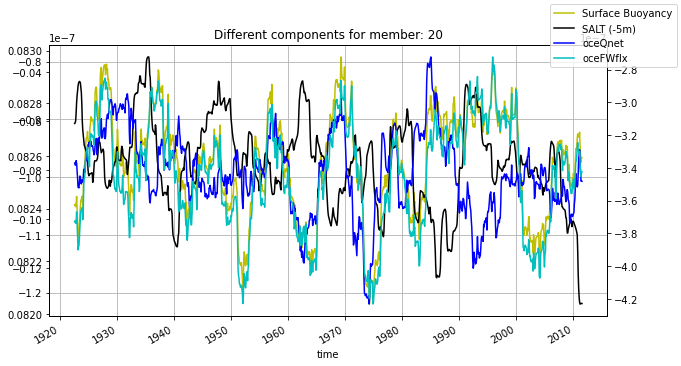

In [244]:
fig=plt.figure(figsize=(10, 5))
plt.subplot(1,1,1)
tc.sel(ens=member-1).sel(time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(color='y', label='Surface Buoyancy')
plt.grid()
plt.title('Different components for member: '+str(member))
plt.twinx()
S.sel(time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(color='k', label='SALT (-5m)')
plt.title('')
plt.twinx()
Q.sel(time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(color='b', label='oceQnet')
plt.twinx()
FW.sel(time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(color='c', label='oceFWflx')
fig.legend()


In [331]:
EXFuwind=xr.open_dataarray('../02_data/maps/EXFuwind_ensmean.nc') #SHELFICE.....
EXFvwind=xr.open_dataarray('../02_data/maps/EXFvwind_ensmean.nc') #SHELFICE....

In [332]:
Uwind=EXFuwind.sel(YC=slice(-75.2, -74.5), XC=slice(251, 252.5))
Uwind=(Uwind*Uwind['rA'])/Uwind['rA'].sum()
Uwind=Uwind.mean(dim=['YC', 'XC'])
Uwind['time']=Uwind.indexes['time'].to_datetimeindex()

Vwind=EXFvwind.sel(YC=slice(-75.2, -74.5), XC=slice(251, 252.5))
Vwind=(Vwind*Vwind['rA'])/Vwind['rA'].sum()
Vwind=Vwind.mean(dim=['YC', 'XC'])
Vwind['time']=Vwind.indexes['time'].to_datetimeindex()

/tmp/ipykernel_17586/37673526.py:4: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  Uwind['time']=Uwind.indexes['time'].to_datetimeindex()
/tmp/ipykernel_17586/37673526.py:9: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  Vwind['time']=Vwind.indexes['time'].to_datetimeindex()


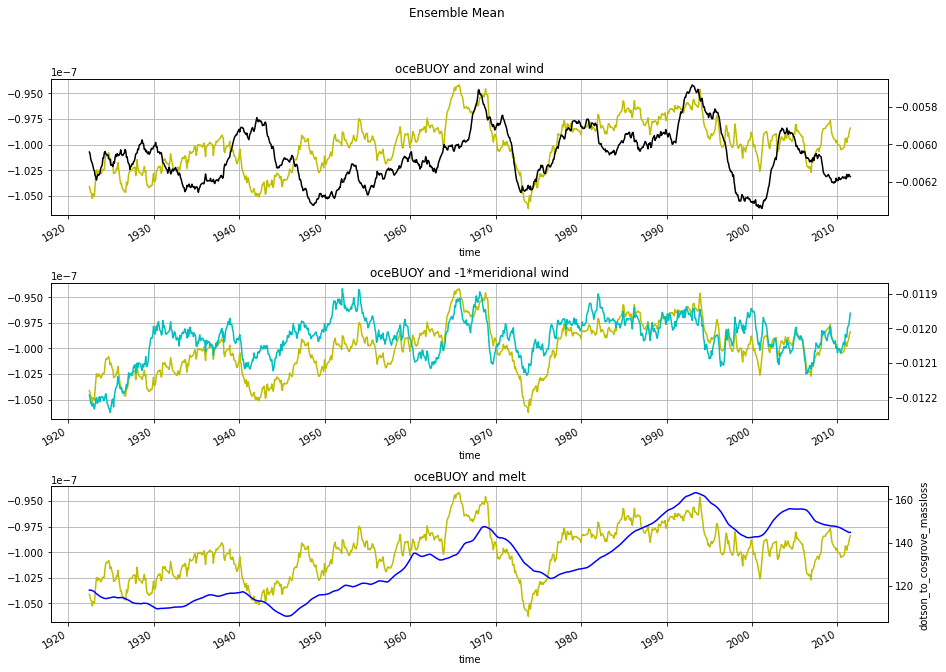

In [333]:
plt.figure(figsize=(15, 10))
plt.suptitle('Ensemble Mean')
plt.subplot(3,1,1)
tc.mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(color='y')
plt.title('oceBUOY and zonal wind')
plt.grid()
plt.twinx()
Uwind.sel(time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(color='k')


plt.subplot(3,1,2)
tc.mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(color='y')
plt.title('oceBUOY and -1*meridional wind')
plt.grid()
plt.twinx()
(-1*Vwind).sel(time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(color='c')

plt.subplot(3,1,3)
tc.mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(color='y')
plt.title('oceBUOY and melt')
plt.grid()
plt.twinx()
melt.mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(color='b')
#plt.title('oceBUOY and melt')
plt.subplots_adjust(hspace=0.5)

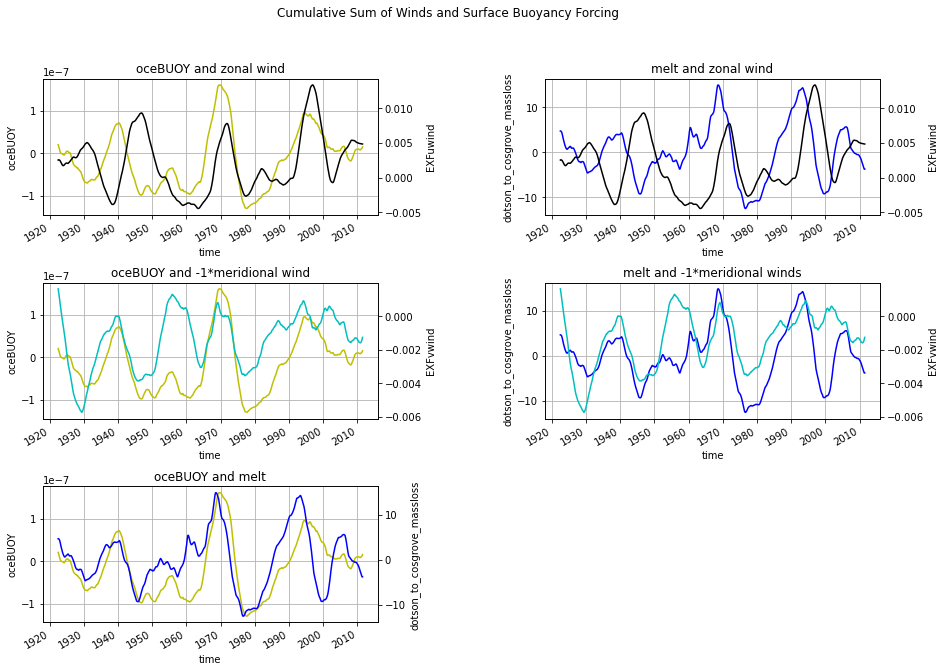

In [344]:
Vwind_dt=detrend_and_average_MITgcmData(Vwind.to_dataset(name='EXFvwind'), var='EXFvwind', window=1)
Uwind_dt=detrend_and_average_MITgcmData(Uwind.to_dataset(name='EXFuwind'), var='EXFuwind', window=1)

plt.figure(figsize=(15, 10))
plt.suptitle('Ensemble Mean')
plt.subplot(3,2,1)
tc_dt.mean(dim='ens').sel(time=slice('1920', '2013')).cumsum(dim='time').rolling(time=60, center=True).mean().plot(color='y')
plt.title('oceBUOY and zonal wind')
plt.grid()
plt.twinx()
(Uwind_dt).sel(time=slice('1920', '2013')).cumsum(dim='time').rolling(time=60, center=True).mean().plot(color='k')

plt.subplot(3,2,2)
melt_dt.mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(color='b')
#plt.title('oceBUOY and zonal wind')
plt.title('melt and zonal wind')
plt.grid()
plt.twinx()
(Uwind_dt).sel(time=slice('1920', '2013')).cumsum(dim='time').rolling(time=60, center=True).mean().plot(color='k')


plt.subplot(3,2,3)
tc_dt.mean(dim='ens').sel(time=slice('1920', '2013')).cumsum(dim='time').rolling(time=60, center=True).mean().plot(color='y')
plt.title('oceBUOY and -1*meridional wind')
plt.grid()
plt.twinx()
(-1*Vwind_dt).sel(time=slice('1920', '2013')).cumsum(dim='time').rolling(time=60, center=True).mean().plot(color='c')

plt.subplot(3,2,4)
melt_dt.mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(color='b')
plt.title('melt and -1*meridional winds')
plt.grid()
plt.twinx()
(-1*Vwind_dt).sel(time=slice('1920', '2013')).cumsum(dim='time').rolling(time=60, center=True).mean().plot(color='c')


plt.subplot(3,2,5)
tc_dt.mean(dim='ens').sel(time=slice('1920', '2013')).cumsum(dim='time').rolling(time=60, center=True).mean().plot(color='y')
plt.title('oceBUOY and melt')
plt.grid()
plt.twinx()
melt_dt.mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(color='b')
#plt.title('oceBUOY and melt')
plt.subplots_adjust(hspace=0.5, wspace=0.5)

plt.suptitle('Cumulative Sum of Winds and Surface Buoyancy Forcing')
plt.savefig('cumulative_winds_buoy_melt_ensmean.png')

In [307]:
member=3
EXFuwind=xr.open_dataarray('../02_data/maps/EXFuwind_ens'+str(member)+'.nc') #SHELFICE.....
EXFvwind=xr.open_dataarray('../02_data/maps/EXFvwind_ens'+str(member)+'.nc') #SHELFICE....
EXFwind=np.sqrt(EXFuwind**2+EXFvwind.values**2)

In [308]:
Uwind=EXFuwind.sel(YC=slice(-75.2, -74.5), XC=slice(251, 252.5))
Uwind=(Uwind*Uwind['rA'])/Uwind['rA'].sum()
Uwind=Uwind.mean(dim=['YC', 'XC'])
Uwind['time']=Uwind.indexes['time'].to_datetimeindex()

Vwind=EXFvwind.sel(YC=slice(-75.2, -74.5), XC=slice(251, 252.5))
Vwind=(Vwind*Vwind['rA'])/Vwind['rA'].sum()
Vwind=Vwind.mean(dim=['YC', 'XC'])
Vwind['time']=Vwind.indexes['time'].to_datetimeindex()


wind=EXFwind.sel(YC=slice(-75.2, -74.5), XC=slice(251, 252.5))
wind=(wind*wind['rA'])/wind['rA'].sum()
wind=wind.mean(dim=['YC', 'XC'])
wind['time']=wind.indexes['time'].to_datetimeindex()


/tmp/ipykernel_17586/1650773229.py:4: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  Uwind['time']=Uwind.indexes['time'].to_datetimeindex()
/tmp/ipykernel_17586/1650773229.py:9: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  Vwind['time']=Vwind.indexes['time'].to_datetimeindex()
/tmp/ipykernel_17586/1650773229.py:15: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between d

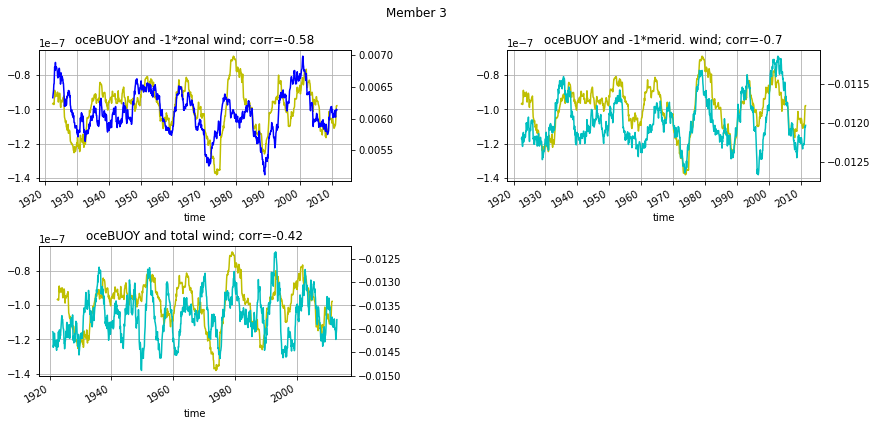

In [309]:
plt.figure(figsize=(14, 6))
plt.suptitle('Member '+str(member))
plt.subplot(2,2,1)
tc.sel(ens=member-1).sel(time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(color='y')
cor=xr.corr(tc.sel(ens=member-1).sel(time=slice('1920', '2013')).rolling(time=60, center=True).mean(),
           Uwind.sel(time=slice('1920', '2013')).rolling(time=60, center=True).mean(), dim='time').to_numpy()
plt.title('oceBUOY and -1*zonal wind; corr='+str(round(float(cor), 2)))
plt.grid()
plt.twinx()
(-1*Uwind).sel(time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(color='b')



plt.subplot(2,2,2)
tc.sel(ens=member-1).sel(time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(color='y')
cor=xr.corr(tc.sel(ens=member-1).sel(time=slice('1920', '2013')).rolling(time=60, center=True).mean(),
           Vwind.sel(time=slice('1920', '2013')).rolling(time=60, center=True).mean(), dim='time').to_numpy()
plt.title('oceBUOY and -1*merid. wind; corr='+str(round(float(cor), 2)))
plt.grid()
plt.twinx()
(-1*Vwind).sel(time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(color='c')

plt.subplot(2,2,3)
tc.sel(ens=member-1).sel(time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(color='y')
cor=xr.corr(tc.sel(ens=member-1).sel(time=slice('1920', '2013')).rolling(time=60, center=True).mean(),
           wind.sel(time=slice('1920', '2013')).rolling(time=60, center=True).mean(), dim='time').to_numpy()
plt.title('oceBUOY and total wind; corr='+str(round(float(cor), 2)))
plt.grid()
plt.twinx()
(-1*wind).sel(time=slice('1920', '2013')).rolling(time=24, center=True).mean().plot(color='c')

plt.subplots_adjust(hspace=0.5, wspace=0.5)

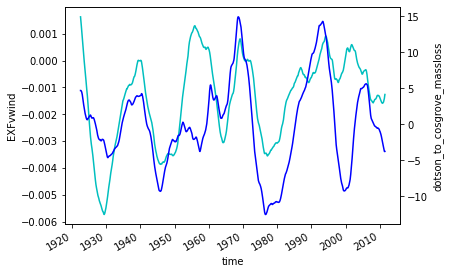

In [330]:
Vwind_dt=detrend_and_average_MITgcmData(Vwind.to_dataset(name='EXFvwind'), var='EXFvwind', window=1)

(-1*Vwind_dt).sel(time=slice('1920', '2013')).cumsum().rolling(time=60, center=True).mean().plot(color='c')
plt.twinx()
#melt.sel(ens=member-1).sel(time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(color='b')
melt_dt.mean(dim='ens').sel(time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(color='b')


In [2]:
data=loadMITgcmData('SALT_averaged_-700to-200', members='all')

Loading number:0
../02_data/maps/SALT_averaged_-700to-200_ens1.nc
Loading number:1
../02_data/maps/SALT_averaged_-700to-200_ens2.nc
Loading number:2
../02_data/maps/SALT_averaged_-700to-200_ens3.nc
Loading number:3
../02_data/maps/SALT_averaged_-700to-200_ens4.nc
Loading number:4
../02_data/maps/SALT_averaged_-700to-200_ens5.nc
Loading number:5
../02_data/maps/SALT_averaged_-700to-200_ens6.nc
Loading number:6
../02_data/maps/SALT_averaged_-700to-200_ens7.nc
Loading number:7
../02_data/maps/SALT_averaged_-700to-200_ens8.nc
Loading number:8
../02_data/maps/SALT_averaged_-700to-200_ens9.nc
Loading number:9
../02_data/maps/SALT_averaged_-700to-200_ens10.nc
Loading number:10
../02_data/maps/SALT_averaged_-700to-200_ens11.nc
Loading number:11
../02_data/maps/SALT_averaged_-700to-200_ens12.nc
Loading number:12
../02_data/maps/SALT_averaged_-700to-200_ens13.nc
Loading number:13
../02_data/maps/SALT_averaged_-700to-200_ens14.nc
Loading number:14
../02_data/maps/SALT_averaged_-700to-200_ens15.nc

In [29]:
#Do this in a proper way (i.e. control for differences in cell size)
sif=data.sel(YC=slice(-75.2, -74.5), XC=slice(251, 252.5))
#sif=(sif['SALT']*sif['rA'])/sif['rA'].sum()
sif=sif['SALT'].mean(dim=['YC', 'XC'])
sif['time']=sif.indexes['time'].to_datetimeindex()

#srb=data.sel(YC=slice(-74, -73), XC=slice(240, 242))
srb=data.sel(YC=slice(-72.5, -72), XC=slice(245, 246))
#sif=(sif['SALT']*sif['rA'])/sif['rA'].sum()
srb=srb['SALT'].mean(dim=['YC', 'XC'])
srb['time']=srb.indexes['time'].to_datetimeindex()

/tmp/ipykernel_11258/3002931869.py:5: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  sif['time']=sif.indexes['time'].to_datetimeindex()
/tmp/ipykernel_11258/3002931869.py:11: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  srb['time']=srb.indexes['time'].to_datetimeindex()


In [10]:
#tc.to_netcdf('../02_data/indices/oceBUOY_icefront.nc')
tif=xr.open_dataarray('../02_data/indices/oceBUOY_icefront.nc')

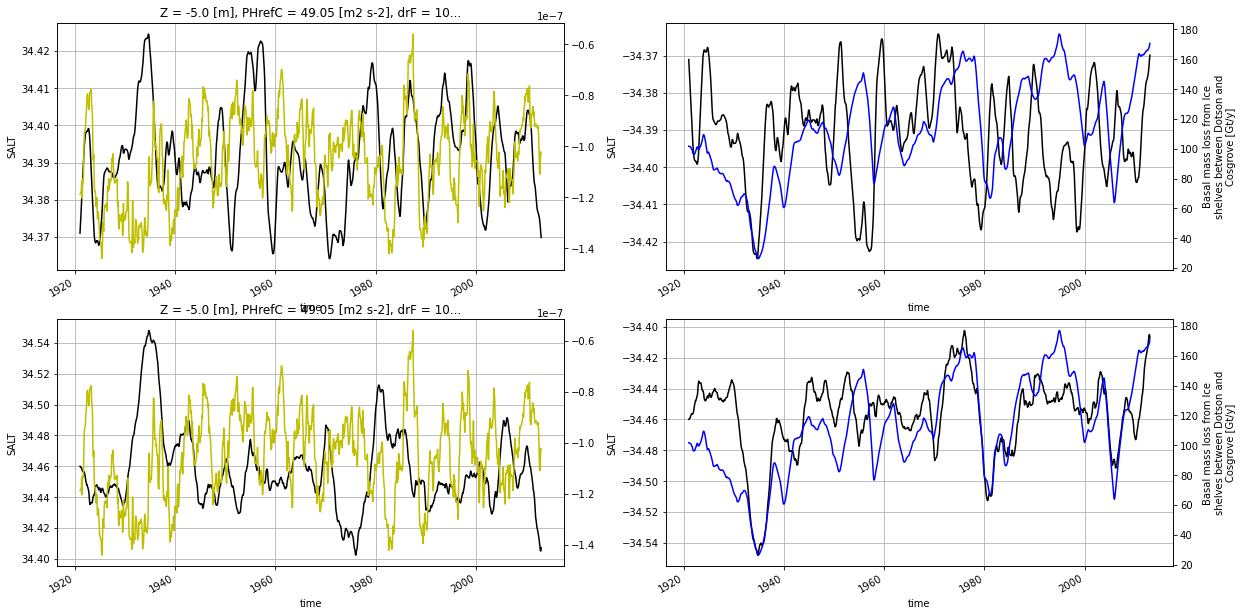

In [30]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
sif.sel(ens=0, time=slice('1920', '2013')).rolling(time=24, center=True).mean().plot(c='k')
plt.grid()
plt.twinx()
tif.sel(ens=0, time=slice('1920', '2013')).rolling(time=24, center=True).mean().plot(c='y')

plt.subplot(2,2,2)
(-1*sif).sel(ens=0, time=slice('1920', '2013')).rolling(time=24, center=True).mean().plot(c='k')
plt.grid()
plt.twinx()
melt.sel(ens=0, time=slice('1920', '2013')).rolling(time=24, center=True).mean().plot(c='b')


plt.subplot(2,2,3)
srb.sel(ens=0, time=slice('1920', '2013')).rolling(time=24, center=True).mean().plot(c='k')
plt.grid()
plt.twinx()
tif.sel(ens=0, time=slice('1920', '2013')).rolling(time=24, center=True).mean().plot(c='y')

plt.subplot(2,2,4)
(-1*srb).sel(ens=0, time=slice('1920', '2013')).rolling(time=24, center=True).mean().plot(c='k')
plt.grid()
plt.twinx()
melt.sel(ens=0, time=slice('1920', '2013')).rolling(time=24, center=True).mean().plot(c='b')

In [31]:
tif_dt=detrend_and_average_MITgcmData(tif.to_dataset(name='oceBUOY'), var='oceBUOY', window=1)
sif_dt=detrend_and_average_MITgcmData(sif.to_dataset(name='oceBUOY'), var='oceBUOY', window=1)
srb_dt=detrend_and_average_MITgcmData(srb.to_dataset(name='oceBUOY'), var='oceBUOY', window=1)
melt_dt=detrend_and_average_MITgcmData(melt.to_dataset(name='dotson_to_cosgrove_massloss'), var='dotson_to_cosgrove_massloss', window=1)

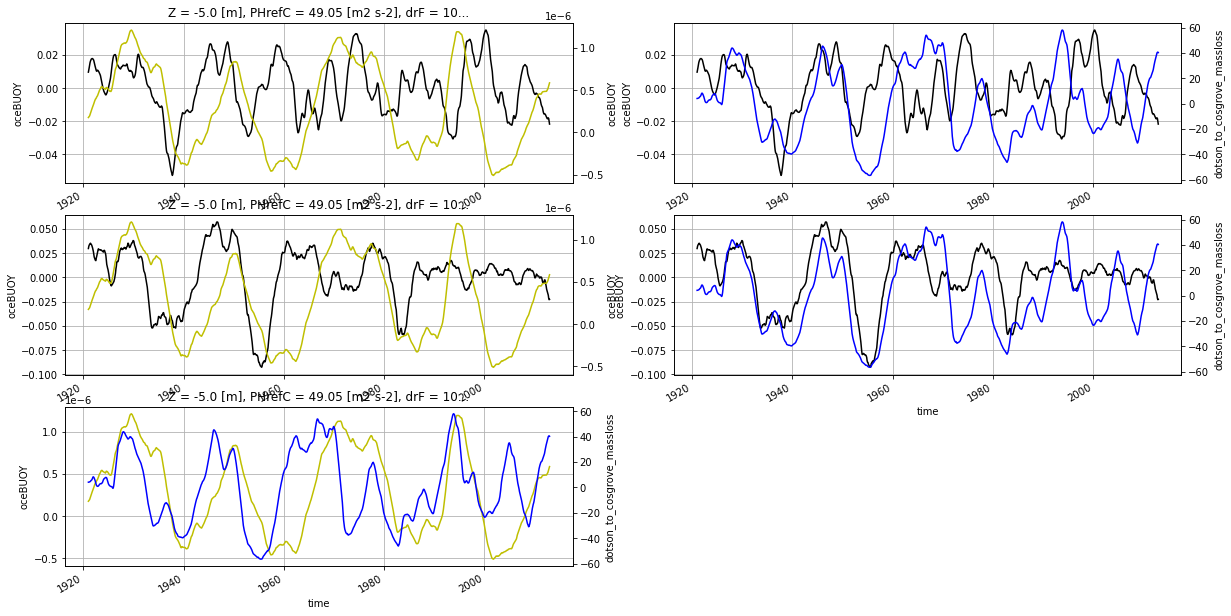

In [32]:
plt.figure(figsize=(20,10))
plt.subplot(3,2,1)
(-1*sif_dt).sel(ens=1, time=slice('1920', '2013')).rolling(time=24, center=True).mean().plot(c='k')
plt.grid()
plt.twinx()
tif_dt.sel(ens=1, time=slice('1920', '2013')).cumsum(dim='time').rolling(time=24, center=True).mean().plot(c='y')

plt.subplot(3,2,2)
(-1*sif_dt).sel(ens=1, time=slice('1920', '2013')).rolling(time=24, center=True).mean().plot(c='k')
plt.grid()
plt.twinx()
melt_dt.sel(ens=1, time=slice('1920', '2013')).rolling(time=24, center=True).mean().plot(c='b')


plt.subplot(3,2,3)
(-1*srb_dt).sel(ens=1, time=slice('1920', '2013')).rolling(time=24, center=True).mean().plot(c='k')
plt.grid()
plt.twinx()
tif_dt.sel(ens=1, time=slice('1920', '2013')).cumsum(dim='time').rolling(time=24, center=True).mean().plot(c='y')

plt.subplot(3,2,4)
(-1*srb_dt).sel(ens=1, time=slice('1920', '2013')).rolling(time=24, center=True).mean().plot(c='k')
plt.grid()
plt.twinx()
melt_dt.sel(ens=1, time=slice('1920', '2013')).rolling(time=24, center=True).mean().plot(c='b')

plt.subplot(3,2,5)
tif_dt.sel(ens=1, time=slice('1920', '2013')).cumsum(dim='time').rolling(time=24, center=True).mean().plot(c='y')
plt.grid()
plt.twinx()
melt_dt.sel(ens=1, time=slice('1920', '2013')).rolling(time=24, center=True).mean().plot(c='b')

In [26]:
adv_dt=detrend_and_average_MITgcmData(adv['PITE'].to_dataset(name='ADVy_TH'), var='ADVy_TH', window=1)

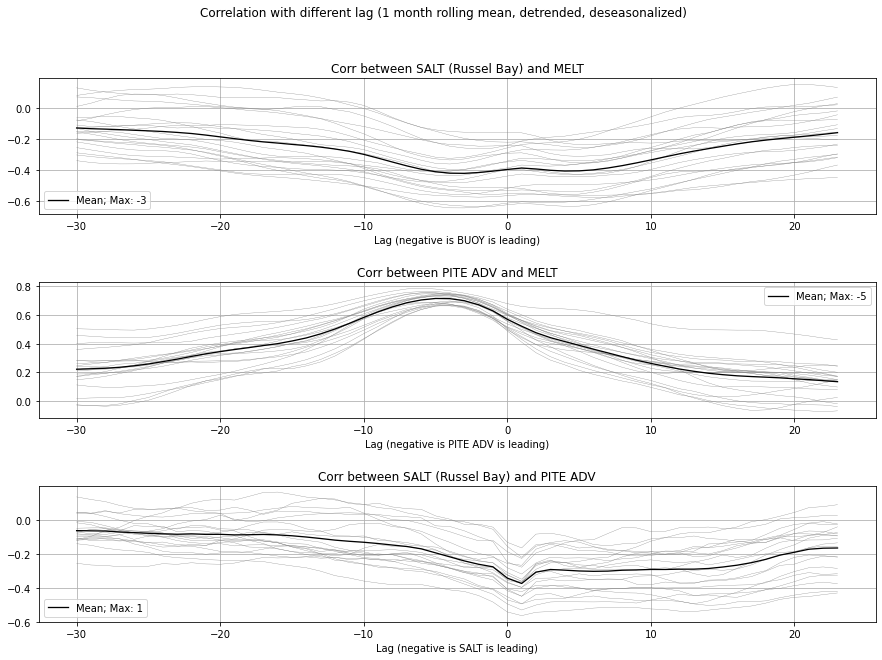

In [35]:
#I should actually detrend this; save alles
window=1
plt.figure(figsize=(15, 10))    
for j in range(20):
    cor1=[]
    cor2=[]
    cor3=[]
#     a=tc.sel(ens=j, time=slice('1920', '2013')).rolling(time=60, center=True).mean()
#     b=melt.sel(ens=j, time=slice('1920', '2013')).rolling(time=60, center=True).mean()
#     c=adv['PITE'].sel(ens=j, time=slice('1920', '2013')).rolling(time=60, center=True).mean()
    
    a=srb_dt.sel(ens=j, time=slice('1920', '2013')).rolling(time=window, center=True).mean()
    b=melt_dt.sel(ens=j, time=slice('1920', '2013')).rolling(time=window, center=True).mean()
    c=adv_dt.sel(ens=j, time=slice('1920', '2013')).rolling(time=window, center=True).mean()

    if window==1:
        def deseasonalize(ds):
            monthly=ds.groupby('time.month').mean()
            return ds.groupby('time.month')-monthly
        a=deseasonalize(a)
        b=deseasonalize(b)
        c=deseasonalize(c)
            
    
    for i in range(-30, 24):
        cor1+=[xr.corr(a, b.shift(time=i), dim='time')]
        cor2+=[xr.corr(c, b.shift(time=i), dim='time')*-1]
        cor3+=[xr.corr(a, c.shift(time=i), dim='time')*-1]
    plt.subplot(3,1,1)
    plt.plot(range(-30, 24), cor1, c='grey', linewidth=0.3)
    plt.subplot(3,1,2)
    plt.plot(range(-30, 24), cor2, c='grey', linewidth=0.3)
    plt.subplot(3,1,3)
    plt.plot(range(-30, 24), cor3, c='grey', linewidth=0.3)
    
    if j==0:
        cor1_list=np.asarray(cor1)
        cor2_list=np.asarray(cor2)
        cor3_list=np.asarray(cor3)
    else:
        cor1_list=np.vstack((cor1_list, cor1))
        cor2_list=np.vstack((cor2_list, cor2))
        cor3_list=np.vstack((cor3_list, cor3))
 
 

plt.subplot(3,1,1)
plt.plot(range(-30, 24), np.mean(cor1_list, axis=0), label='Mean; Max: '+str(np.argmax(abs(np.mean(cor1_list, axis=0)))-30), c='black', linewidth=1.3)
plt.subplot(3,1,2)
plt.plot(range(-30, 24), np.mean(cor2_list, axis=0), label='Mean; Max: '+str(np.argmax(abs(np.mean(cor2_list, axis=0)))-30), c='black', linewidth=1.3)
plt.subplot(3,1,3)
plt.plot(range(-30, 24), np.mean(cor3_list, axis=0), label='Mean; Max: '+str(np.argmax(abs(np.mean(cor3_list, axis=0)))-30), c='black', linewidth=1.3)


plt.subplot(3,1,1)
plt.grid()
plt.xlabel('Lag (negative is BUOY is leading)')
plt.title('Corr between SALT (Russel Bay) and MELT')
plt.legend()
plt.subplot(3,1,2)
plt.grid()
plt.xlabel('Lag (negative is PITE ADV is leading)')
plt.title('Corr between PITE ADV and MELT')
plt.legend()

plt.subplot(3,1,3)
plt.grid()
plt.xlabel('Lag (negative is SALT is leading)')
plt.title('Corr between SALT (Russel Bay) and PITE ADV')
plt.legend()

if window==1:
    plt.suptitle('Correlation with different lag ('+str(window)+' month rolling mean, detrended, deseasonalized)')
else:
    plt.suptitle('Correlation with different lag ('+str(window)+' month rolling mean, detrended)')

plt.subplots_adjust(hspace=0.5)

plt.savefig('../03_output/other/lag_SALTrb_melt_and_current_rm'+str(window)+'.png')

In [40]:
ens=5
SALTmap=xr.open_dataarray('../02_data/maps/SALT_averaged_-700to-200_ens'+str(ens)+'.nc')
SALTZ5=xr.open_dataarray('../02_data/maps/Z5_SALT_ens'+str(ens)+'.nc')
SALT115=xr.open_dataarray('../02_data/slices/SALT_W115_ens'+str(ens)+'.nc')
SALT123=xr.open_dataarray('../02_data/slices/SALT_W123_ens'+str(ens)+'.nc')

SALTmap['time']=SALTmap.indexes['time'].to_datetimeindex()
SALTZ5['time']=SALTZ5.indexes['time'].to_datetimeindex()
SALT115['time']=SALT115.indexes['time'].to_datetimeindex()
SALT123['time']=SALT123.indexes['time'].to_datetimeindex()

/tmp/ipykernel_80429/2675641493.py:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  SALTmap['time']=SALTmap.indexes['time'].to_datetimeindex()
/tmp/ipykernel_80429/2675641493.py:8: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  SALTZ5['time']=SALTZ5.indexes['time'].to_datetimeindex()
/tmp/ipykernel_80429/2675641493.py:9: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time betw

In [36]:
window=12
a=SALTmap.sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean()
b=tc.sel(ens=ens-1, time=slice('1920', '2013')).rolling(time=window, center=True).mean()
res=xr.corr(a, b, dim='time')

<a list of 24 text.Text objects>

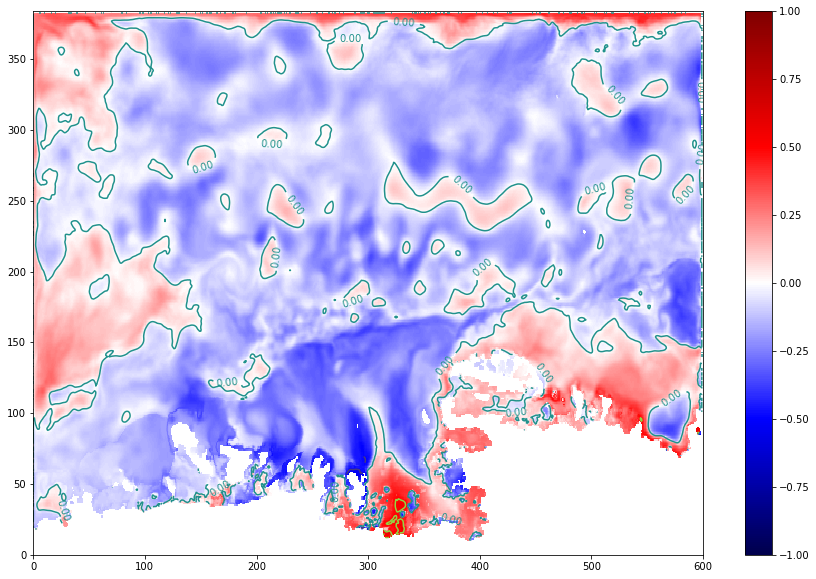

In [37]:
plt.figure(figsize=(15,10))
plt.pcolor(res, cmap='seismic', vmin=-1, vmax=1)
plt.colorbar()
cn=plt.contour(res, [-0.75, -0.5, 0, 0.5, 0.75])
plt.clabel(cn, [-0.75, -0.5, 0, 0.5, 0.75])


In [38]:
window=12
a=SALTmap.sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean()
b=melt.sel(ens=ens-1, time=slice('1920', '2013')).rolling(time=window, center=True).mean()
res=xr.corr(a, b, dim='time')

<a list of 38 text.Text objects>

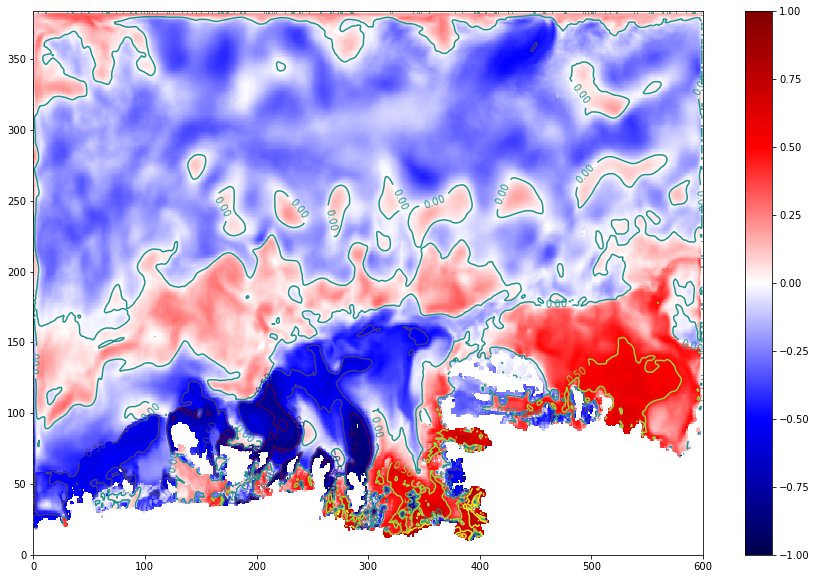

In [39]:
plt.figure(figsize=(15,10))
plt.pcolor(res, cmap='seismic', vmin=-1, vmax=1)
plt.colorbar()
cn=plt.contour(res, [-0.75, -0.5, 0, 0.5, 0.75])
plt.clabel(cn, [-0.75, -0.5, 0, 0.5, 0.75])


<a list of 10 text.Text objects>

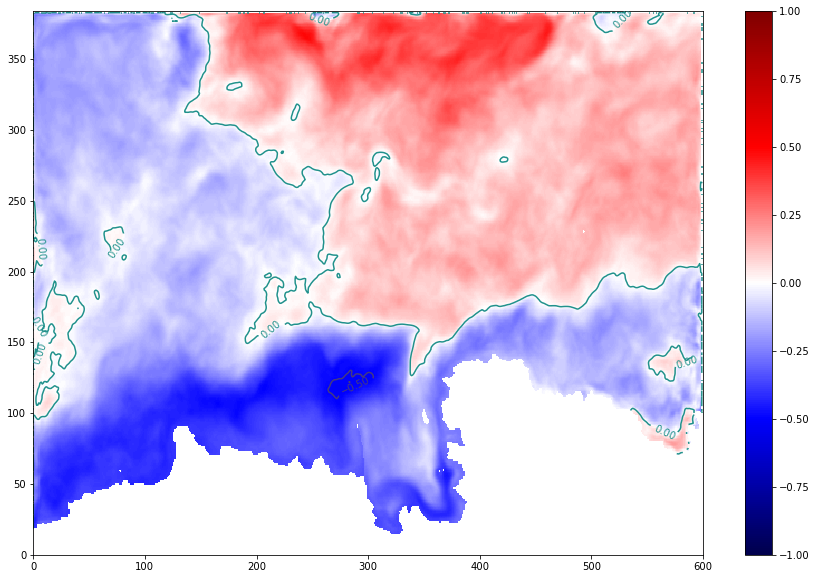

In [42]:
window=12
a=SALTZ5.sel(time=slice('1920', '2013')).rolling(time=window, center=True).mean()
#b=tc.sel(ens=ens-1, time=slice('1920', '2013')).rolling(time=window, center=True).mean()
b=melt.sel(ens=ens-1, time=slice('1920', '2013')).rolling(time=window, center=True).mean()
res=xr.corr(a, b, dim='time')

plt.figure(figsize=(15,10))
plt.pcolor(res, cmap='seismic', vmin=-1, vmax=1)
plt.colorbar()
cn=plt.contour(res, [-0.75, -0.5, 0, 0.5, 0.75])
plt.clabel(cn, [-0.75, -0.5, 0, 0.5, 0.75])

In [85]:
ens=18
SALTmap=xr.open_dataarray('../02_data/maps/SALT_averaged_-700to-200_ens'+str(ens)+'.nc')
SALTmap['time']=SALTmap.indexes['time'].to_datetimeindex()

/tmp/ipykernel_11258/1460475717.py:3: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  SALTmap['time']=SALTmap.indexes['time'].to_datetimeindex()


In [86]:
SALThv=SALTmap.sel(XC=slice(245, 252), YC=slice(-75.5, -71), time=slice('1920', '2013'))
SALThv=detrend_and_average_MITgcmData(SALThv.to_dataset(name='SALT'), var='SALT')
SALThv=SALThv.mean(dim='XC')

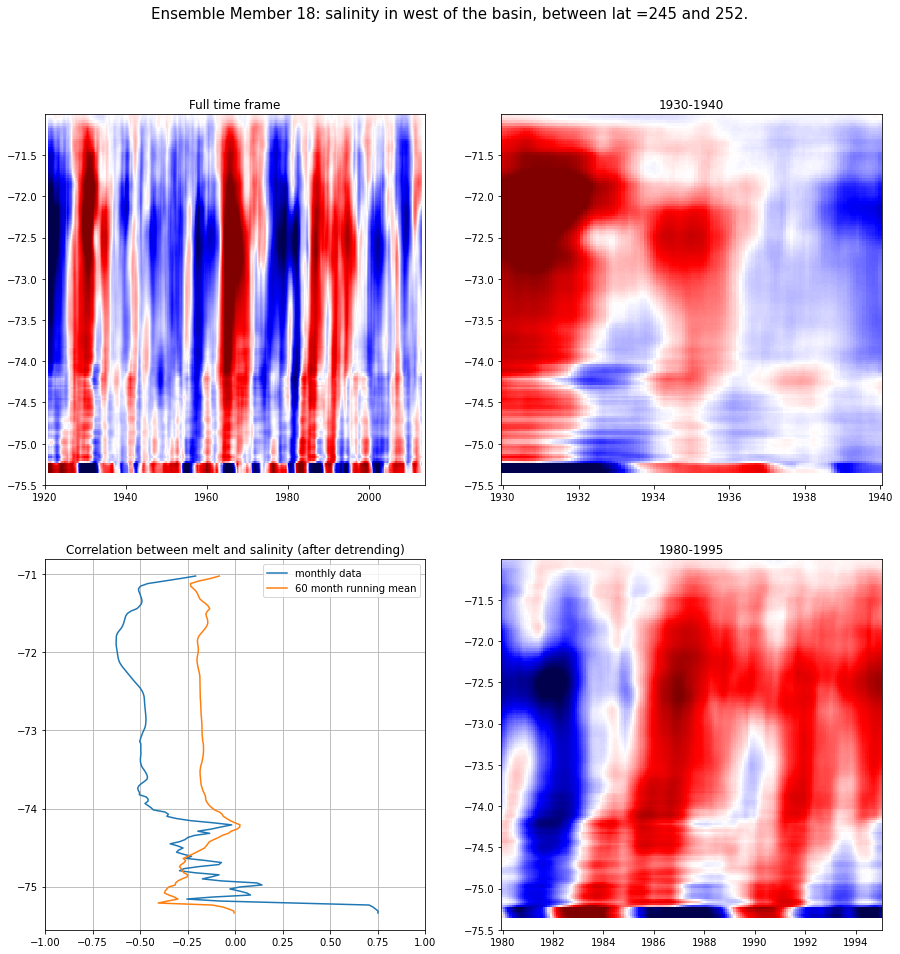

In [87]:
plt.figure(figsize=(15,15))
plt.suptitle('Ensemble Member '+str(ens)+': salinity in west of the basin, between lat =245 and 252.', fontsize=(15))
plt.subplot(2,2,1)
plt.pcolor(np.linspace(1920, 2014, len(SALThv.time)), SALThv.YC, SALThv.T, cmap='seismic', vmin=-0.05, vmax=0.05)
plt.title('Full time frame')
plt.subplot(2,2,2)
plt.pcolor(np.linspace(1930, 1940,len(SALThv.sel(time=slice('1930', '1939')).time)), SALThv.YC, SALThv.sel(time=slice('1930', '1939')).T, cmap='seismic', vmin=-0.05, vmax=0.05)
plt.title('1930-1940')

plt.subplot(2,2,3)
SALThv_dt=detrend_and_average_MITgcmData(SALThv.to_dataset(name='SALT'), var='SALT')
#=detrend_and_average_MITgcmData(SALThv.to_dataset(name='SALT'), var='SALT')
a=xr.corr(SALThv_dt, melt_dt.sel(ens=ens-1, time=slice('1920', '2013')), dim='time')
b=xr.corr(SALThv_dt.rolling(time=60, center=True).mean(), melt_dt.sel(ens=4, time=slice('1920', '2013')).rolling(time=60, center=True).mean(), dim='time')
plt.plot(a, a.YC, label='monthly data')
plt.plot(b, b.YC, label='60 month running mean')
plt.grid()
plt.xlim([-1, 1])
plt.title('Correlation between melt and salinity (after detrending)')
plt.legend()

plt.subplot(2,2,4)
plt.pcolor(np.linspace(1980, 1995,len(SALThv.sel(time=slice('1980', '1994')).time)), SALThv.YC, SALThv.sel(time=slice('1980', '1994')).T, cmap='seismic', vmin=-0.05, vmax=0.05)
plt.title('1980-1995')

plt.savefig('../03_output/other/hovmoller_salinity_ens'+str(ens)+'.png')

(-1.0, 1.0)

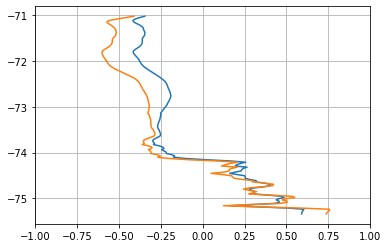

In [85]:
SALThv=SALT115.sel(YC=slice(-74, -71), time=slice('1920', '2013'))
SALThv=detrend_and_average_MITgcmData(SALThv.to_dataset(name='SALT'), var='SALT')
SALThv=SALThv.mean(dim='Z')

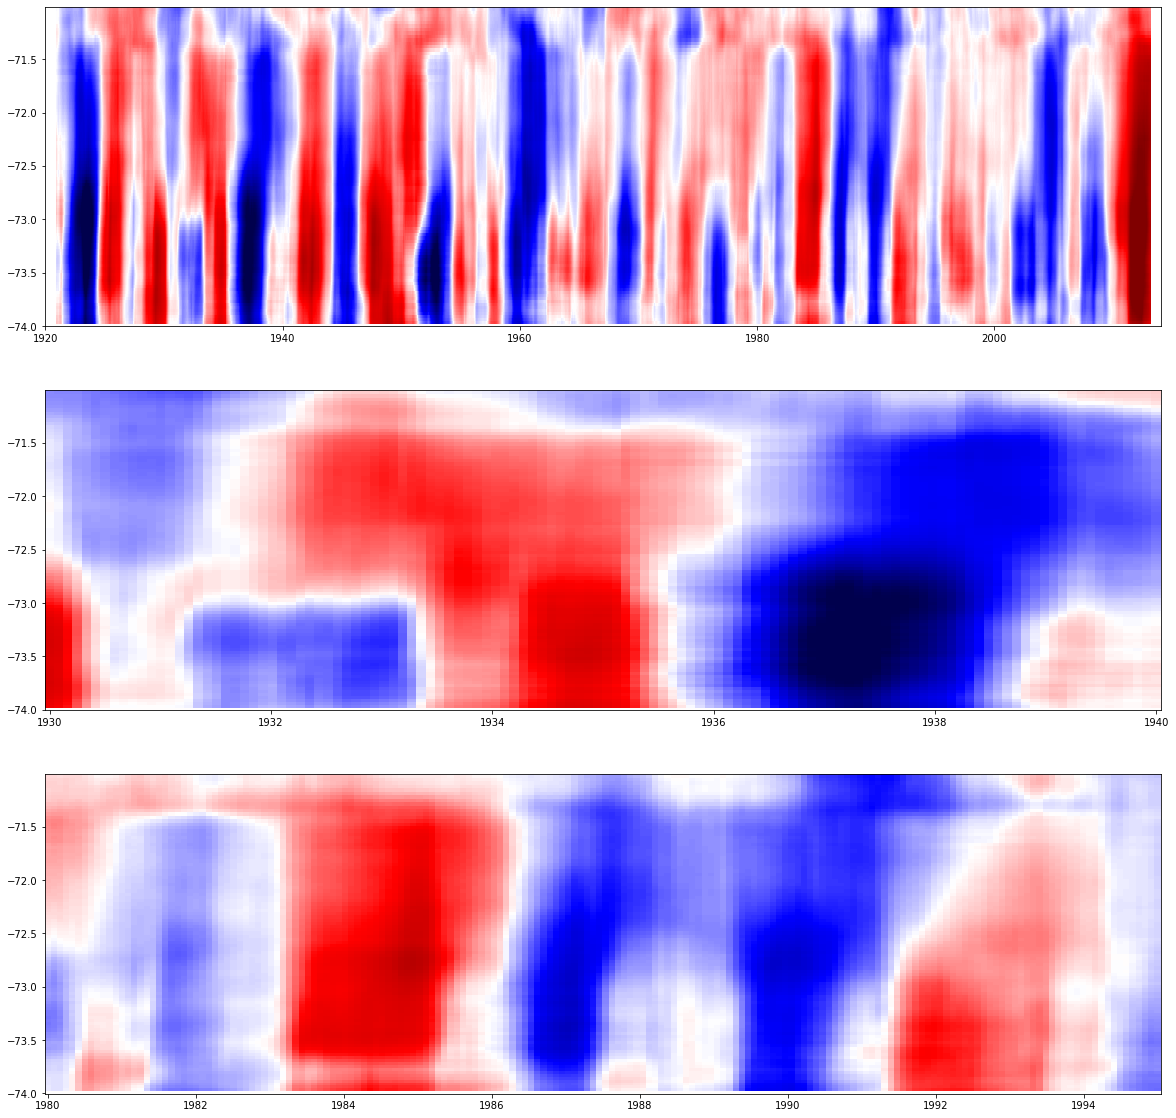

In [86]:
plt.figure(figsize=(20,20))
plt.subplot(3,1,1)
plt.pcolor(np.linspace(1920, 2014, len(SALThv.time)), SALThv.YC, SALThv.T, cmap='seismic', vmin=-0.05, vmax=0.05)
plt.subplot(3,1,2)
plt.pcolor(np.linspace(1930, 1940,len(SALThv.sel(time=slice('1930', '1939')).time)), SALThv.YC, SALThv.sel(time=slice('1930', '1939')).T, cmap='seismic', vmin=-0.05, vmax=0.05)
plt.subplot(3,1,3)
plt.pcolor(np.linspace(1980, 1995,len(SALThv.sel(time=slice('1980', '1994')).time)), SALThv.YC, SALThv.sel(time=slice('1980', '1994')).T, cmap='seismic', vmin=-0.05, vmax=0.05)

In [87]:
SALThv=SALT115.sel(YC=slice(-74, -71), time=slice('1920', '2013'))
SALThv=detrend_and_average_MITgcmData(SALThv.to_dataset(name='SALT'), var='SALT')
SALThv=SALThv.mean(dim='YC')

(-2000.0, 0.0)

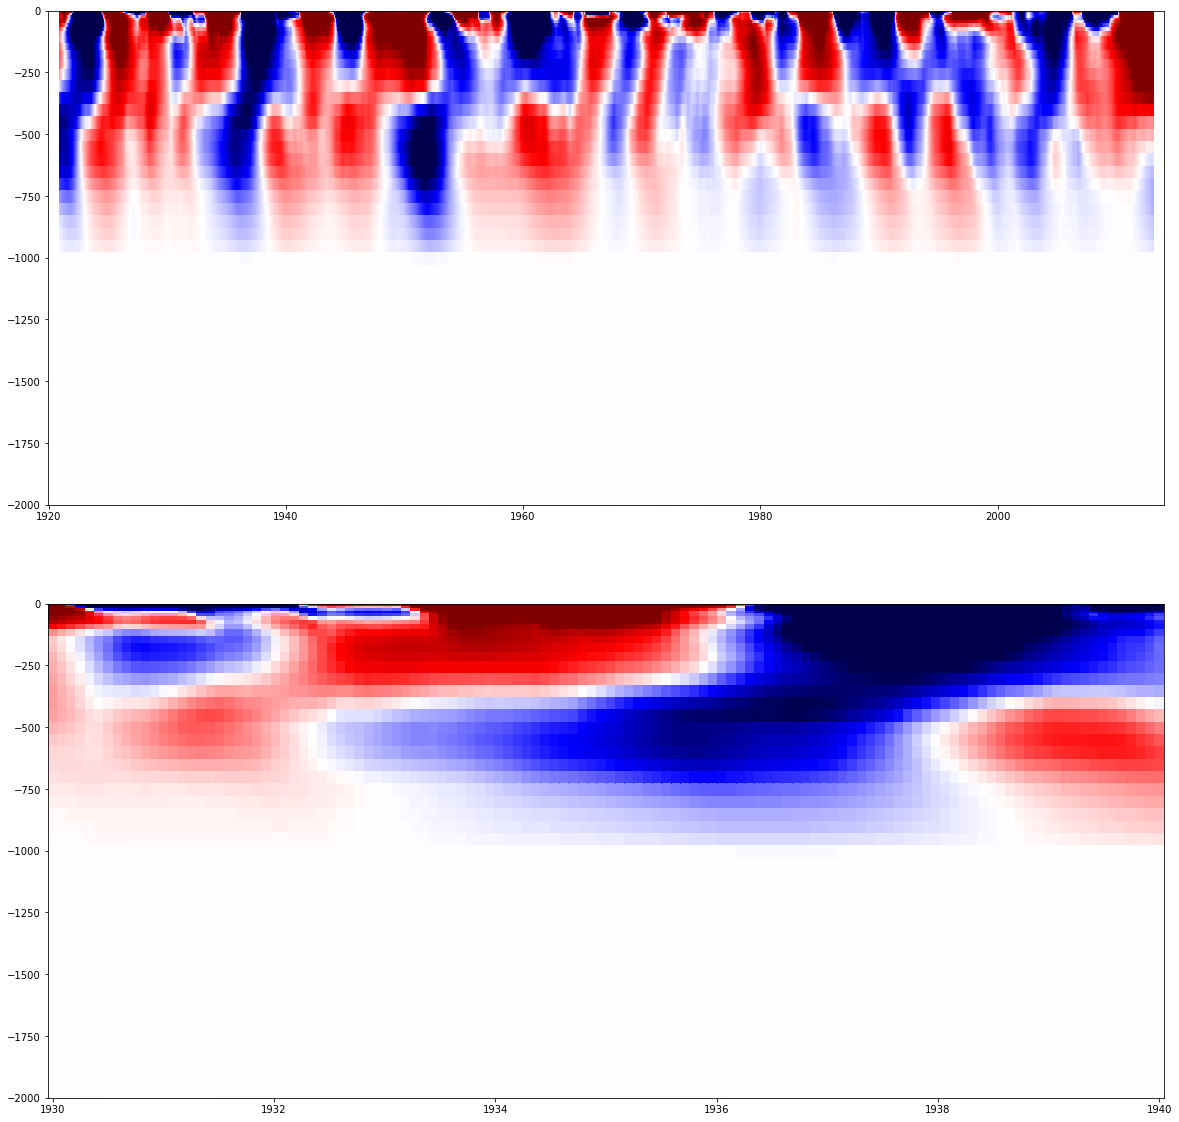

In [88]:
plt.figure(figsize=(20,20))
plt.subplot(2,1,1)
plt.pcolor(np.linspace(1920, 2014, len(SALThv.time)), SALThv.Z, SALThv.T, cmap='seismic', vmin=-0.05, vmax=0.05)
plt.ylim([-2000, 0])
plt.subplot(2,1,2)
plt.pcolor(np.linspace(1930, 1940,len(SALThv.sel(time=slice('1930', '1939')).time)), SALThv.Z, SALThv.sel(time=slice('1930', '1939')).T, cmap='seismic', vmin=-0.05, vmax=0.05)
plt.ylim([-2000, 0])

In [92]:
SALT115=xr.open_dataarray('../02_data/slices/UVEL_W115_ens'+str(ens)+'.nc')
SALT115['time']=SALT115.indexes['time'].to_datetimeindex()


SALThv=SALT115.sel(YC=slice(-74, -70), time=slice('1920', '2013'))
SALThv=detrend_and_average_MITgcmData(SALThv.to_dataset(name='SALT'), var='SALT')
SALThv=SALThv.mean(dim='Z')

/tmp/ipykernel_80429/1863482706.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  SALT115['time']=SALT115.indexes['time'].to_datetimeindex()


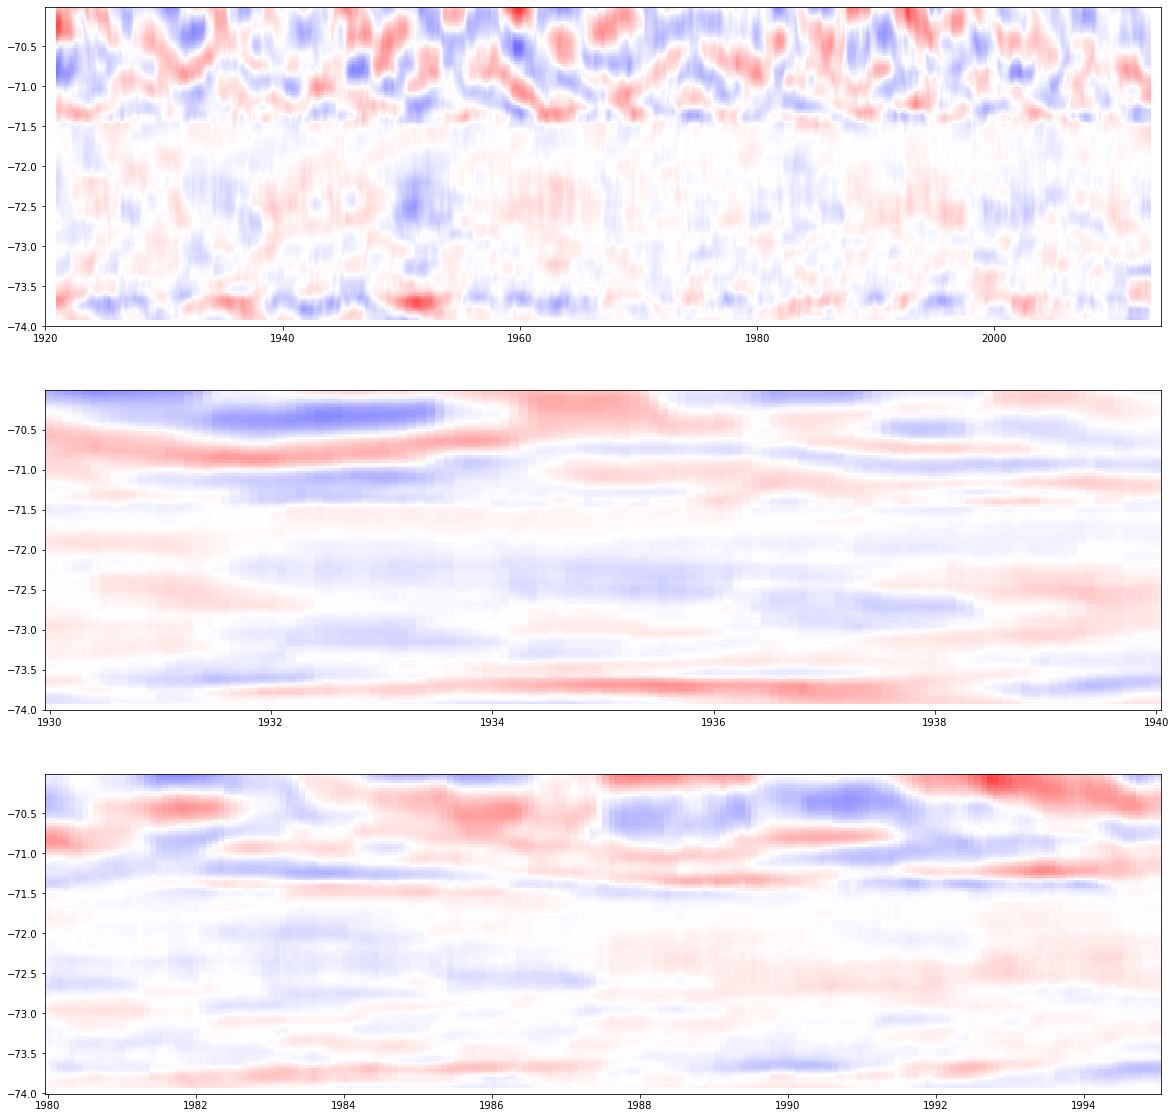

In [93]:
plt.figure(figsize=(20,20))
plt.subplot(3,1,1)
plt.pcolor(np.linspace(1920, 2014, len(SALThv.time)), SALThv.YC, SALThv.T, cmap='seismic', vmin=-0.05, vmax=0.05)
plt.subplot(3,1,2)
plt.pcolor(np.linspace(1930, 1940,len(SALThv.sel(time=slice('1930', '1939')).time)), SALThv.YC, SALThv.sel(time=slice('1930', '1939')).T, cmap='seismic', vmin=-0.05, vmax=0.05)
plt.subplot(3,1,3)
plt.pcolor(np.linspace(1980, 1995,len(SALThv.sel(time=slice('1980', '1994')).time)), SALThv.YC, SALThv.sel(time=slice('1980', '1994')).T, cmap='seismic', vmin=-0.05, vmax=0.05)

In [96]:
SALT115=xr.open_dataarray('../02_data/slices/UVEL_W115_ens'+str(ens)+'.nc')
SALT115['time']=SALT115.indexes['time'].to_datetimeindex()
SALThv=SALT115.sel(YC=slice(-72, -70), time=slice('1920', '2013'))
SALThv=detrend_and_average_MITgcmData(SALThv.to_dataset(name='SALT'), var='SALT')
SALThv=SALThv.mean(dim='YC')

/tmp/ipykernel_80429/915633518.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  SALT115['time']=SALT115.indexes['time'].to_datetimeindex()


(-2000.0, 0.0)

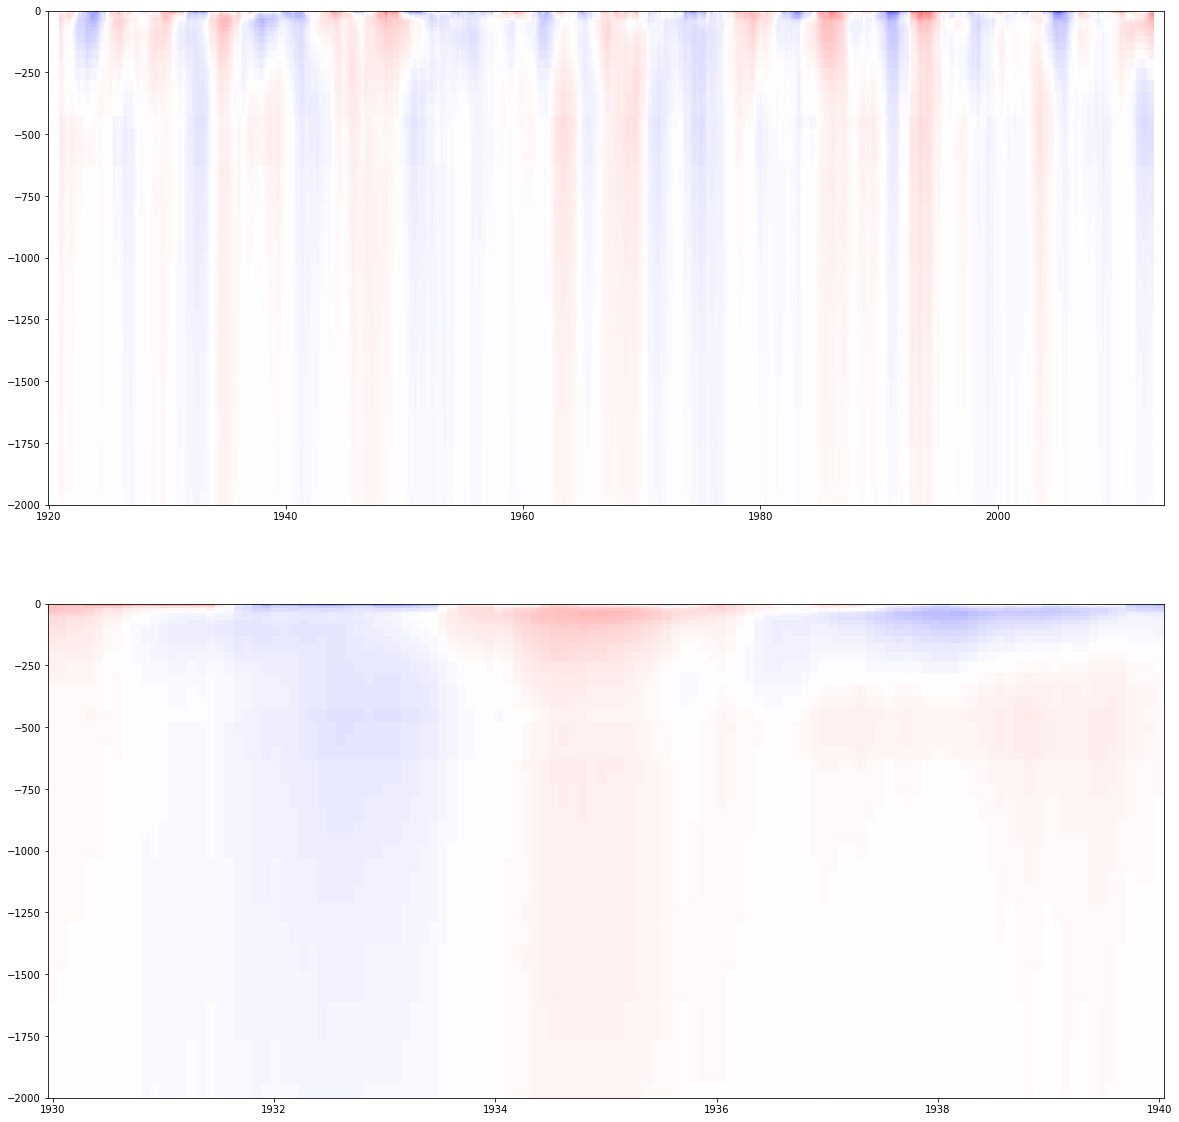

In [97]:
plt.figure(figsize=(20,20))
plt.subplot(2,1,1)
plt.pcolor(np.linspace(1920, 2014, len(SALThv.time)), SALThv.Z, SALThv.T, cmap='seismic', vmin=-0.05, vmax=0.05)
plt.ylim([-2000, 0])
plt.subplot(2,1,2)
plt.pcolor(np.linspace(1930, 1940,len(SALThv.sel(time=slice('1930', '1939')).time)), SALThv.Z, SALThv.sel(time=slice('1930', '1939')).T, cmap='seismic', vmin=-0.05, vmax=0.05)
plt.ylim([-2000, 0])

In [89]:
tc=data.sel(YC=slice(-75.5, -74.5), XC=slice(251, 254))
tc=(tc['oceBUOY']*tc['rA'])/tc['rA'].sum()
tc=tc.mean(dim=['YC', 'XC'])
print(tc)

a=data.sel(YC=slice(-75.5, -74.5), XC=slice(251, 254)).mean(dim=['YC', 'XC'])
print(a)

plt.plot(a['oceBUOY'].sel(ens=1).rolling(time=24).mean())
plt.twinx()
plt.plot(tc.sel(ens=1).rolling(time=24).mean(), c='r')

NameError: name 'data' is not defined

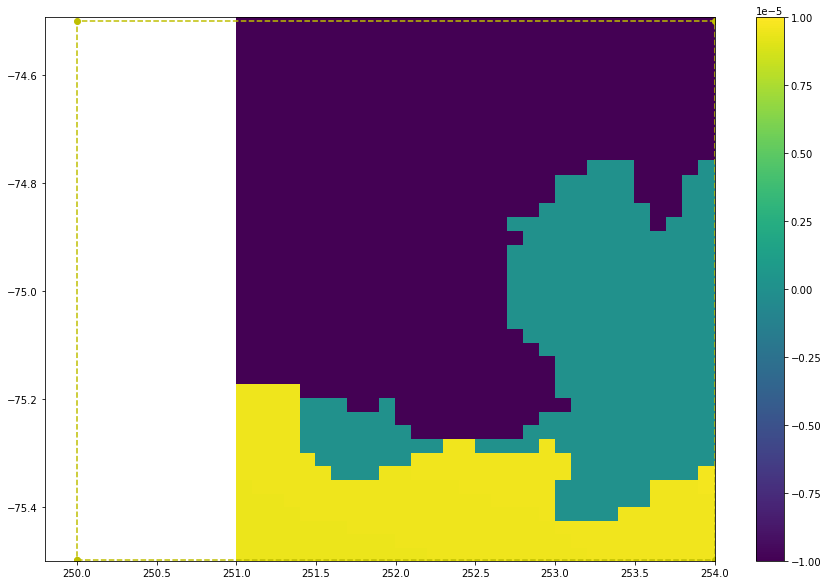

In [41]:
tc=data.sel(YC=slice(-75.5, -74.5), XC=slice(251, 254))

plt.figure(figsize=(15,10))
plt.pcolor(tc['oceBUOY'].sel(ens=0).XC, tc['oceBUOY'].sel(ens=0).YC, tc['oceBUOY'].sel(ens=0).sel(time=slice('1920', '2013')).mean(dim='time'), vmin=-1e-5, vmax=1e-5)
plt.colorbar()
plt.plot([250, 254, 254, 250, 250], [-75.5, -75.5, -74.5, -74.5, -75.5], 'yo--')

In [31]:
tc=data.sel(YC=slice(-75.5, -74.5), XC=slice(251, 254))
factor=tc['rA']/(tc['rA'].sum())
tc=tc['oceBUOY']*factor
tc=tc.mean(dim=['YC', 'XC'])
tc.sel(ens=0).mean()

<xarray.DataArray ()>
array(-2.1823961e-08, dtype=float32)
Coordinates:
    Z        float32 -5.0
    PHrefC   float32 49.05
    drF      float32 10.0

In [186]:
np.shape(cor2_list)

(20, 48)

In [42]:
data

<xarray.Dataset>
Dimensions:  (time: 1488, XC: 600, YC: 384, ens: 20)
Coordinates:
    iter     (time) int64 4464 8496 12960 17280 ... 6508656 6512976 6517440
  * time     (time) object 1890-02-01 00:00:00 ... 2014-01-01 00:00:00
  * XC       (XC) float32 220.1 220.1 220.2 220.4 ... 279.6 279.8 279.9 280.0
  * YC       (YC) float32 -75.64 -75.61 -75.59 -75.56 ... -62.48 -62.44 -62.39
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 4.71e+03 4.683e+03 4.673e+03
    rA       (YC, XC) float32 7.604e+06 7.604e+06 ... 2.652e+07 2.652e+07
    Z        float32 -5.0
    PHrefC   float32 49.05
    drF      float32 10.0
    hFacC    (YC, XC) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0 1.0
Dimensions without coordinates: ens
Data variables:
    oceBUOY  (ens, time, YC, XC) float32 2.443e-05 2.448e-05 ... 1.592e-05

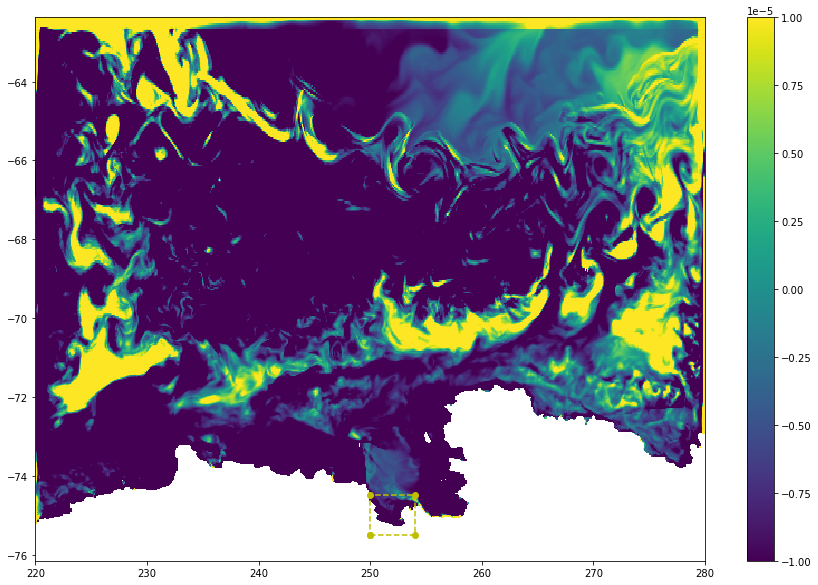

In [57]:
temp=data['oceBUOY'].sel(ens=0).where(data['Depth']!=0, drop=True).where(data['oceBUOY'].isel(ens=0, time=1000)!=0, drop=True)
plt.figure(figsize=(15,10))
plt.pcolor(temp.XC, temp.YC, temp.sel(time=slice('1920', '2013')).isel(time=20), vmin=-1e-5, vmax=1e-5)
plt.plot([250, 254, 254, 250, 250], [-75.5, -75.5, -74.5, -74.5, -75.5], 'yo--')
plt.colorbar()

In [56]:
temp

<xarray.DataArray 'oceBUOY' (time: 1488, YC: 375, XC: 600)>
array([[[          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        ...,
        [4.9980255e-03, 2.7410864e-04, 1.1596665e-04, ...,
         1.8525177e-05, 1.8629249e-05, 1.9350648e-05],
        [4.9866904e-03, 3.0917849e-04, 1.6541337e-04, ...,
         1.8795197e-05, 1.8890323e-05, 1.9390267e-05],
        [4.8781135e-03, 4.9970308e-03, 4.9267695e-03, ...,
         1.9690367e-05, 1.9677933e-05, 1.9429124e-05]],

       [[          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
...
        [1.9249462e-03, 7.8938843e-04, 4.0416812e-04, ...,
         9.7001684e-06, 9.7305137e-06, 8.7656030e-05],
        [1.9925379e-03, 8.0416753e-04, 4.4787535e-04, ...,
         9.2681339e-06, 9.3420449e-06, 5.3095475e-05],
        [2.0602320e-03, 1.9034395e-03, 1.9250755e-03, ...,
         9.7276134e-05, 9.9792393e-05, 3.0271516e-05]],

       [[          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        [          nan,           nan,           nan, ...,
                   nan,           nan,           nan],
        ...,
        [3.8584536e-03, 1.3925579e-03, 5.0373538e-04, ...,
         1.4120483e-05, 1.3878933e-05, 1.4612924e-05],
        [3.9384058e-03, 1.3900528e-03, 6.3884881e-04, ...,
         1.3940137e-05, 1.3782984e-05, 1.4215689e-05],
        [4.0185489e-03, 3.8697820e-03, 3.8584722e-03, ...,
         1.4966517e-05, 1.4921595e-05, 1.3815240e-05]]], dtype=float32)
Coordinates:
  * YC       (YC) float64 -75.41 -75.39 -75.36 -75.34 ... -62.48 -62.44 -62.39
    iter     (time) int64 4464 8496 12960 17280 ... 6508656 6512976 6517440
  * time     (time) object 1890-02-01 00:00:00 ... 2014-01-01 00:00:00
  * XC       (XC) float32 220.1 220.1 220.2 220.4 ... 279.6 279.8 279.9 280.0
    Depth    (YC, XC) float32 0.0 0.0 0.0 0.0 ... 4.71e+03 4.683e+03 4.673e+03
    rA       (YC, XC) float32 7.845e+06 7.845e+06 ... 2.652e+07 2.652e+07
    Z        float32 -5.0
    PHrefC   float32 49.05
    drF      float32 10.0
    hFacC    (YC, XC) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0 1.0

In [183]:
np.shape(cor2_list)

(1, 48, 20)

In [196]:
np.shape(cor1_list.mean(axis=1))

(20,)

In [197]:
cor1_list.mean(axis=1)

array([0.56029139, 0.72996026, 0.49856107, 0.74002522, 0.52829234,
       0.02471109, 0.4164591 , 0.32314064, 0.40312174, 0.46728552,
       0.44579014, 0.65452318, 0.54628995, 0.86370318, 0.80281202,
       0.69343764, 0.55634178, 0.60210447, 0.28155442, 0.33222179])

Text(0, 0.5, 'Basal Mass Loss (Dotson-Cosgrove)')

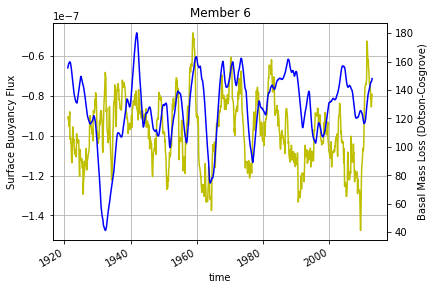

In [203]:
    
i=5
tc.sel(ens=i).sel(time=slice('1920', '2013')).rolling(time=24, center=True).mean().plot(color='y')
plt.title('Member '+str(i+1))
plt.ylabel('Surface Buoyancy Flux')
plt.grid()
plt.twinx()
melt.sel(ens=i, time=slice('1920', '2013')).rolling(time=24, center=True).mean().plot(color='b')
plt.ylabel('Basal Mass Loss (Dotson-Cosgrove)')

In [201]:
tc.sel(ens=5)

<xarray.DataArray (time: 1488)>
array([ 1.17804277e-07, -9.93370275e-09, -1.30064777e-07, ...,
       -2.05312229e-08,  2.69856972e-08,  1.16970654e-07], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1890-02-01 1890-03-01 ... 2014-01-01
    Z        float32 -5.0
    PHrefC   float32 49.05
    drF      float32 10.0

In [2]:
import os
os.listdir('/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE01/output/194001/MITgcm/')

['output.nc']

In [4]:
xr.open_dataset('/data/oceans_output/shelf/kaight/mitgcm/PAS_PACE01/output/193901/MITgcm/output.nc')

<xarray.Dataset>
Dimensions:   (time: 12, YC: 384, XC: 600, XG: 600, YG: 384, Z: 50, Zl: 50, Zu: 50, Zp1: 51)
Coordinates: (12/26)
    iter      (time) int64 ...
  * time      (time) object 1939-02-01 00:00:00 ... 1940-01-01 00:00:00
  * XC        (XC) float32 220.1 220.1 220.2 220.4 ... 279.6 279.8 279.9 280.0
  * YC        (YC) float32 -75.64 -75.61 -75.59 -75.56 ... -62.48 -62.44 -62.39
  * XG        (XG) float32 220.0 220.1 220.2 220.3 ... 279.6 279.7 279.8 279.9
  * YG        (YG) float32 -75.65 -75.63 -75.6 -75.58 ... -62.51 -62.46 -62.41
    ...        ...
    drC       (Zp1) float32 ...
    PHrefF    (Zp1) float32 ...
    drF       (Z) float32 ...
    hFacS     (Z, YG, XC) float32 ...
    hFacC     (Z, YC, XC) float32 ...
    hFacW     (Z, YC, XG) float32 ...
Data variables: (12/33)
    EXFswdn   (time, YC, XC) float32 ...
    EXFuwind  (time, YC, XC) float32 ...
    EXFvwind  (time, YC, XC) float32 ...
    EXFlwdn   (time, YC, XC) float32 ...
    EXFpress  (time, YC, XC) float32 ...
    EXFatemp  (time, YC, XC) float32 ...
    ...        ...
    THETA     (time, Z, YC, XC) float32 ...
    DFrI_TH   (time, Zl, YC, XC) float32 ...
    KPPg_TH   (time, Zl, YC, XC) float32 ...
    ADVy_TH   (time, Z, YG, XC) float32 ...
    ADVr_TH   (time, Zl, YC, XC) float32 ...
    ADVx_TH   (time, Z, YC, XG) float32 ...